In [1]:
import pandas as pd
import os
import numpy as np
from functions import *
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import re
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
SV clean up
"""
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

In [3]:
"""
full filter and rare
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full') & (kicsSVdf['GD_AF'] < 0.01)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full') & (lfsSVdf['GD_AF'] < 0.01)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].astype(str)
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].str.replace(" ", "")
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].str.replace(" ", "")


In [4]:
"""
Kics clinic df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)

In [5]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
        
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

In [7]:
UberbigKDf = kIdAbbv(kicsClinicdf, kicsSVdf, 'CCP germline', 'sample_id')
bigKDf = UberbigKDf[['sample_id','tumour_class','tissue_type','lfs_cancer_type_diagnosis',
                     'abbv_id','diagnosis_age (days)','CCP germline','SV type']]
bigKDf=bigKDf.rename(columns={'diagnosis_age (days)': 'ageofonset'})
print(len(bigKDf['abbv_id'].unique()))

#prints out how many we had before the id matching and how many we have left after the id matching

191
try2
93


In [8]:
print(bigKDf)
print(UberbigKDf)

      sample_id       tumour_class tissue_type lfs_cancer_type_diagnosis  \
0        313703         CNS TUMORS         CNS                    Glioma   
1        313703         CNS TUMORS         CNS                    Glioma   
2        313703         CNS TUMORS         CNS                    Glioma   
3        313703         CNS TUMORS         CNS                    Glioma   
4        313703         CNS TUMORS         CNS                    Glioma   
...         ...                ...         ...                       ...   
16734    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16735    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16736    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16737    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16738    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   

      abbv_id ageofonset CCP germline SV type  
0      313703       1952       313703  

In [9]:
"""Filter the ? and the nan"""
bigKDf.drop(bigKDf.loc[bigKDf['tissue_type']=='?'].index, inplace=True)

print(len(bigKDf['abbv_id'].unique()))


93


In [10]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [11]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [12]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""
UberbigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsClinicdf,
                 left_on = 'sample_id',
                 right_on = 'sample',
                 how='inner')
bigLDf = UberbigLDf[['sample_id','SV chrom','GD_AF', 'SV type','sample',
                     'tissue_type','cancer_diagnosis','ageofonset']]

print(bigLDf)
print(UberbigLDf)

     sample_id SV chrom     GD_AF SV type sample tissue_type cancer_diagnosis  \
0         4257        1  0.000047     DEL   4257      Breast           Breast   
1         4257        1  0.000338     DEL   4257      Breast           Breast   
2         4257        1  0.002795     DEL   4257      Breast           Breast   
3         4257        1  0.005914     DEL   4257      Breast           Breast   
4         4257        1 -1.000000     DEL   4257      Breast           Breast   
...        ...      ...       ...     ...    ...         ...              ...   
8381      2765        9 -1.000000     DEL   2765     Adrenal              ACC   
8382      2765        X -1.000000     DEL   2765     Adrenal              ACC   
8383      2765        X -1.000000     INV   2765     Adrenal              ACC   
8384      2765        X  0.009091     DEL   2765     Adrenal              ACC   
8385      2765        Y -1.000000     DEL   2765     Adrenal              ACC   

      ageofonset  
0       

In [13]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(bigLDf['tissue_type']).symmetric_difference(set(bigKDf['tissue_type'])))
diagDiff = list(set(bigLDf['cancer_diagnosis']).symmetric_difference(set(bigKDf['lfs_cancer_type_diagnosis'])))

print(tissueDiff)
print(diagDiff)

['Other', 'Thyroid', 'Ovaries', 'Unaffected']
['PNET', 'CPC', 'MFH', 'AMKL', 'CSA', 'T-NHL', 'Thyroid', 'Unaffected', 'AML', 'Undifferentiated sarcoma', 'ALL', 'US', 'LMS', 'T-LL', 'Meningioma', 'MFS', 'AL', 'Other', 'B-ALL', 'Ovaries', 'AA', 'High Grade Sarcoma', 'MPAL']


In [14]:
"""
Drop the rows that are in the diff
"""

####YOU DROPPED TOO MANY, Don't drop any
#bigLDf.drop(bigLDf[bigLDf['tissue_type'].isin(tissueDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['tissue_type'].isin(tissueDiff)].index, inplace = True)

#bigLDf.drop(bigLDf[bigLDf['cancer_diagnosis'].isin(diagDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['lfs_cancer_type_diagnosis'].isin(diagDiff)].index, inplace = True)

kicsTissue = pd.DataFrame(data = {'tissue_type':bigKDf['tissue_type'], 'id':bigKDf['sample_id']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':bigLDf['tissue_type'], 'id':bigLDf['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':bigLDf['cancer_diagnosis'], 'id':bigLDf['sample']})
# lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':bigKDf['lfs_cancer_type_diagnosis'], 'id':bigKDf['sample_id']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = list(kicsDiag['diag'].unique())
lfsDiagList = list(lfsDiag['diag'].unique())

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = list(kicsTissue['tissue_type'].unique())
lfsTissueList = list(lfsTissue['tissue_type'].unique())
lfsIdList = lfsTissue['id'].unique()

uniqueTissue = list(set(kicsTissueList+lfsTissueList))
uniqueDiag = list(set(kicsDiagList+lfsDiagList))

print(uniqueTissue)
print(uniqueDiag)

['Adrenal', 'Soft Tissue', 'CNS', 'Other', 'Breast', 'Colon', 'Blood', 'Thyroid', 'Ovaries', 'Unaffected', 'US', 'Bone']
['PNET', 'MFH', 'AMKL', 'CSA', 'T-NHL', 'Unaffected', 'AML', 'ALL', 'US', 'ACC', 'LMS', 'T-LL', 'MFS', 'Breast', 'Colon', 'AL', 'B-ALL', 'High Grade Sarcoma', 'OS', 'CPC', 'RMS', 'Thyroid', 'Undifferentiated sarcoma', 'Glioma', 'Other', 'Ovaries', 'AA', 'Meningioma', 'MPAL']


# Diagnosis Type

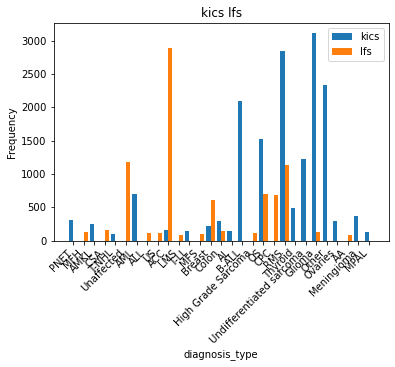

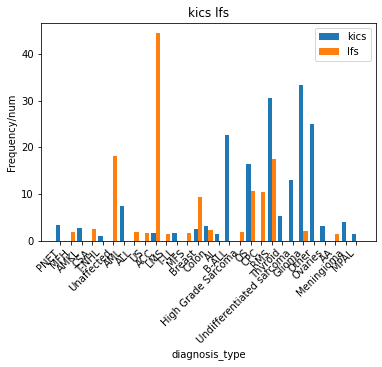

In [15]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, uniqueDiag)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), uniqueDiag)

# Tissue Type

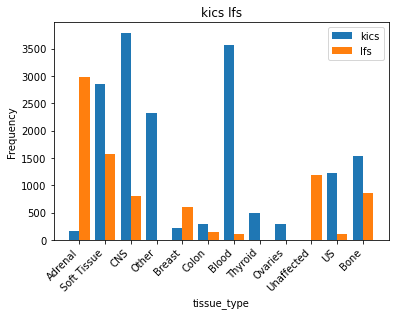

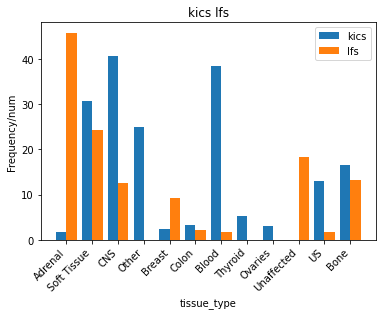

In [16]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, uniqueTissue)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), uniqueTissue)

In [17]:
bigKDf.rename(columns = {'lfs_cancer_type_diagnosis':'cancer_diagnosis'}, inplace = True)

kDel = bigKDf.loc[bigKDf['SV type'] == 'DEL']
kDup = bigKDf.loc[bigKDf['SV type'] == 'DUP']
kInv = bigKDf.loc[bigKDf['SV type'] == 'INV']

lDel = bigLDf.loc[bigLDf['SV type'] == 'DEL']
lDup = bigLDf.loc[bigLDf['SV type'] == 'DUP']
lInv = bigLDf.loc[bigLDf['SV type'] == 'INV']

print(kDel.head(30))
print(lDel.head(30))

   sample_id tumour_class tissue_type cancer_diagnosis abbv_id ageofonset  \
0     313703   CNS TUMORS         CNS           Glioma  313703       1952   
1     313703   CNS TUMORS         CNS           Glioma  313703       1952   
3     313703   CNS TUMORS         CNS           Glioma  313703       1952   
4     313703   CNS TUMORS         CNS           Glioma  313703       1952   
5     313703   CNS TUMORS         CNS           Glioma  313703       1952   
6     313703   CNS TUMORS         CNS           Glioma  313703       1952   
7     313703   CNS TUMORS         CNS           Glioma  313703       1952   
8     313703   CNS TUMORS         CNS           Glioma  313703       1952   
9     313703   CNS TUMORS         CNS           Glioma  313703       1952   
10    313703   CNS TUMORS         CNS           Glioma  313703       1952   
11    313703   CNS TUMORS         CNS           Glioma  313703       1952   
12    313703   CNS TUMORS         CNS           Glioma  313703       1952   

LFS
  sample_id cancer_diagnosis  freq dataset
9      2349              RMS    73     lfs
the outliers for RMS are:
['2349']

   sample_id cancer_diagnosis  freq dataset
58  PD13489b               OS   242     lfs
the outliers for OS are:
['PD13489b']

KICS
   sample_id cancer_diagnosis  freq dataset
14    284386              RMS   532    kics
the outliers for RMS are:
['284386']

  sample_id cancer_diagnosis  freq dataset
7    271112               OS   417    kics
the outliers for OS are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.895e-01 U_stat=2.000e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.225e-02 U_stat=2.050e+01


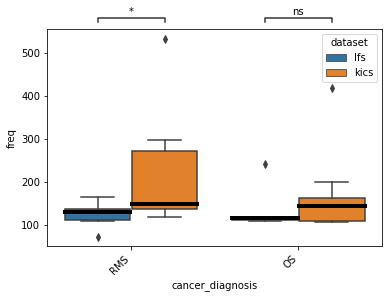

LFS
   sample_id  tissue_type  freq dataset
9       2349  Soft Tissue    73     lfs
41      3763  Soft Tissue   164     lfs
the outliers for Soft Tissue are:
['2349', '3763']

   sample_id tissue_type  freq dataset
27      3356         CNS   322     lfs
the outliers for CNS are:
['3356']

   sample_id tissue_type  freq dataset
58  PD13489b        Bone   242     lfs
the outliers for Bone are:
['PD13489b']

KICS
   sample_id tissue_type  freq dataset
9     271116         CNS   369    kics
16    286909         CNS   484    kics
36    300683         CNS   472    kics
the outliers for CNS are:
['271116', '286909', '300683']

   sample_id  tissue_type  freq dataset
14    284386  Soft Tissue   532    kics
the outliers for Soft Tissue are:
['284386']

  sample_id tissue_type  freq dataset
7    271112        Bone   417    kics
the outliers for Bone are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 

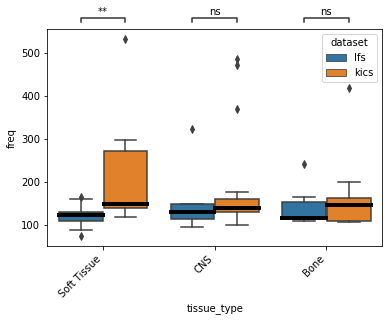

In [18]:
kicsTissue = bigKDf.drop(['CCP germline', 'tumour_class', 'cancer_diagnosis'], axis=1)
kicsDiag = bigKDf.drop(['CCP germline', 'tumour_class', 'tissue_type'], axis=1)

lfsTissue = bigLDf.drop(['cancer_diagnosis', 'sample'],axis=1)
lfsDiag = bigLDf.drop(['tissue_type', 'sample'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, False)

#print(lfsTissue)
graphSVTissue(kicsTissue, lfsTissue,True)

# RMS and Soft Tissue Breakdown

In [19]:
#DEL, DUP, INV specific Soft Tissue and RMS

kDf = UberbigKDf[['sample_id', 'SV type', 'abbv_id', 'KiCS ID', 'ICDO-diagnosis',
       'tissue_type', 'lfs_cancer_type_diagnosis','Previous cancers', 'Germline Sample from',
       'Germline sample type', 'CCP germline.1', 'WGS DNA germline',
       'WGS germline', 'pathology_id', 'Sample type', 'CCP tumor', 'CCP PPID',
       'CCP', 'WGS tumor ID', 'WGS Tumor', 'RNA ID', 'RNA',
       'single_somatic_specimen', 'disease_state', 'sample_type',
       'post_treatment', 'sample site', 'tumour_class', 'Sex',
       'diagnosis_age (days)', 'no_chemo_or_xrt']]

#use ICDO-diagnosis

lDf = UberbigLDf[['sample_id', 'SV chrom', 'GD_AF', 'SV type', 'sample',
       'tm_donor', 'tissue_type', 'cancer_diagnosis', 'active_cancer',
       'gender', 'systemic_treatment_atdraw', 'ageofonset', 'agesamplecollection',
       'cancer_num', 'cancer1_age_diff', 'cancer1', 'cancer1_ageofonset',
       'cancer2', 'cancer2_ageofonset', 'cancer3', 'cancer3_ageofonset',
       'cancer4', 'cancer4_ageofonset', 'cancer5', 'cancer5_ageofonset',
       'cancer6', 'cancer6_ageofonset', 'cancer7', 'cancer7_ageofonset',
       'cancer8', 'cancer8_ageofonset']]
#use Cancer 1

#overall diagnosis -> RMS and overall Soft Tissue tissue type <-
kST = kDf.loc[kDf['tissue_type']=='Soft Tissue']
kST = kST[['sample_id', 'SV type', 'ICDO-diagnosis', 'lfs_cancer_type_diagnosis']]
lST = lDf.loc[lDf['tissue_type']=='Soft Tissue']
lST = lST[['sample_id', 'SV type', 'cancer1', 'cancer_diagnosis']]

group = kST.drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS Soft Tissue Mappings')
print(group)
print()

group1 = lST.drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('Overall LFS Soft Tissue Mappings')
print(group1)
print()

krms = kDf.loc[kDf['lfs_cancer_type_diagnosis']=='RMS']
krms = krms[['sample_id', 'SV type', 'ICDO-diagnosis', 'tissue_type']]
lrms = lDf.loc[lDf['cancer_diagnosis']=='RMS']
lrms = lrms[['sample_id', 'SV type', 'cancer1', 'tissue_type']]

group2 = krms.drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS RMS Mappings')
print(group2)
print()

group2 = lrms.drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('Overall LFS RMS Mappings')
print(group2)
print()

Overall KiCS Soft Tissue Mappings
                                                                                  0
sample_id   ICDO-diagnosis                           lfs_cancer_type_diagnosis     
18_4156     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        147
18_7027     8920/3 - Alveolar rhabdomyosarcoma       RMS                        149
273308      8920/3 - Alveolar rhabdomyosarcoma       RMS                        288
284386      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        532
297043      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        131
298866      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        132
305082      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        258
315488      8920/3 - Alveolar rhabdomyosarcoma       RMS                        271
326693      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        298
332546      8910/3 - Embryonal rhabdomyosa

In [20]:
#KICS
#Del
group3 = kST.loc[kST['SV type']=='DEL'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('DEL KiCS Soft Tissue Mappings')
print(group3)
print()
#Dup
group4 = kST.loc[kST['SV type']=='DUP'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('DUP KiCS Soft Tissue Mappings')
print(group4)
print()

#Inv
group5 = kST.loc[kST['SV type']=='INV'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('INV KiCS Soft Tissue Mappings')
print(group5)
print()

DEL KiCS Soft Tissue Mappings
                                                                                  0
sample_id   ICDO-diagnosis                           lfs_cancer_type_diagnosis     
18_4156     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        136
18_7027     8920/3 - Alveolar rhabdomyosarcoma       RMS                        132
273308      8920/3 - Alveolar rhabdomyosarcoma       RMS                        262
284386      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        456
297043      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        114
298866      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        115
305082      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        216
315488      8920/3 - Alveolar rhabdomyosarcoma       RMS                        222
326693      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        242
332546      8910/3 - Embryonal rhabdomyosarcom

In [21]:
#LFS
#Del
group6 = lST.loc[lST['SV type']=='DEL'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('DEL KiCS Soft Tissue Mappings')
print(group6)
print()
#Dup
group7 = lST.loc[lST['SV type']=='DUP'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('DUP KiCS Soft Tissue Mappings')
print(group7)
print()

#Inv
group8 = lST.loc[lST['SV type']=='INV'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('INV KiCS Soft Tissue Mappings')
print(group8)
print()

DEL KiCS Soft Tissue Mappings
                                                               0
sample_id cancer1                        cancer_diagnosis       
1092      Malignant fibrous histiocytoma MFH                 111
1355      Anaplastic ERMS                RMS                 118
1843      High Grade Sarcoma             High Grade Sarcoma  105
2085      ARMS_ERMS                      RMS                 120
2262      Anaplastic ERMS                RMS                 113
2349      Anaplastic ERMS                RMS                  62
2463      Leiomyosarcoma                 LMS                  76
3136A     Anaplastic ERMS                RMS                  99
3634      Myxofibrosarcoma               MFS                  92
3763      Anaplastic ERMS                RMS                 153
4227      Alveolar Rhabdomyosarcoma      RMS                 118
4329      Embryonal rhabdomyosarcoma     RMS                 138
93        Rhabdomyosarcoma               RMS                

## DEL

['Adrenal', 'Soft Tissue', 'CNS', 'Other', 'Breast', 'Colon', 'Blood', 'Thyroid', 'Ovaries', 'Unaffected', 'US', 'Bone']
LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
9       2349   2349  Soft Tissue              RMS    62     lfs          NaN   
41      3763   3763  Soft Tissue              RMS   153     lfs          NaN   

   CCP germline  
9           NaN  
41          NaN  
the outliers for Soft Tissue are:
['2349', '3763']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC   276     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
58  PD13489b  PD13489b        Bone               OS   221     lfs   

   tumour_class CCP germline  
58          NaN          NaN  
the outliers for Bone are:
['PD13489b']

KICS
   sample_id sample tissue_type cancer_diagnosis  

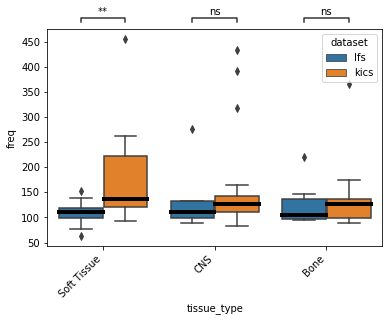

In [22]:
print(uniqueTissue)

graphSVTissue(kDel, lDel, True)


LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
9       2349   2349  Soft Tissue              RMS    62     lfs          NaN   
41      3763   3763  Soft Tissue              RMS   153     lfs          NaN   

   CCP germline  
9           NaN  
41          NaN  
the outliers for RMS are:
['2349', '3763']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
58  PD13489b  PD13489b        Bone               OS   221     lfs   

   tumour_class CCP germline  
58          NaN          NaN  
the outliers for OS are:
['PD13489b']

KICS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset  tumour_class  \
14    284386    NaN  Soft Tissue              RMS   456    kics  SOLID TUMORS   

   CCP germline  
14       284386  
the outliers for RMS are:
['284386']

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
7    271112    NaN        Bone               OS   366    kics  SOLID TUMORS   

  CCP germline  

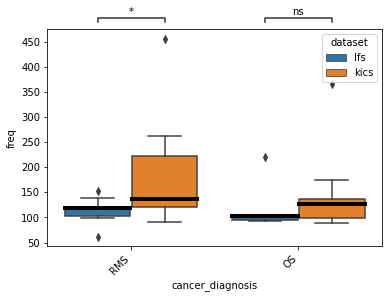

In [23]:

graphSVTissue(kDel, lDel, False)


## DUP

['CNS', 'Soft Tissue', 'Blood', 'Bone', 'Other', 'US', 'Thyroid', 'Breast', 'Colon', 'Adrenal', 'Ovaries']
LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
49      4329   4329  Soft Tissue              RMS    14     lfs          NaN   

   CCP germline  
49          NaN  
the outliers for Soft Tissue are:
['4329']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC    30     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
25      3332   3332        Bone               OS     6     lfs          NaN   

   CCP germline  
25          NaN  
the outliers for Bone are:
['3332']

KICS
   sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
9     271116    NaN         CNS       Meningioma    33    kics    CNS TUMORS   
16    286909    NaN 

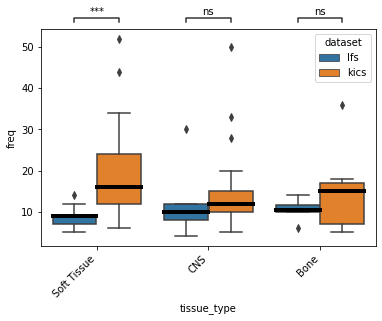

In [24]:
print(kicsTissueList)
graphSVTissue(kDup, lDup, True)


LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
47      4227   4227  Soft Tissue              RMS    12     lfs          NaN   
49      4329   4329  Soft Tissue              RMS    14     lfs          NaN   

   CCP germline  
47          NaN  
49          NaN  
the outliers for RMS are:
['4227', '4329']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
25      3332   3332        Bone               OS     6     lfs          NaN   

   CCP germline  
25          NaN  
the outliers for OS are:
['3332']

KICS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset  tumour_class  \
14    284386    NaN  Soft Tissue              RMS    52    kics  SOLID TUMORS   
79    326693    NaN  Soft Tissue              RMS    44    kics  SOLID TUMORS   

   CCP germline  
14       284386  
79       326693  
the outliers for RMS are:
['284386', '326693']

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class 

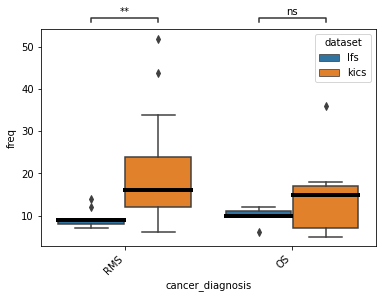

In [25]:
graphSVTissue(kDup, lDup, False)


## INV

LFS
Empty DataFrame
Columns: [sample_id, sample, tissue_type, cancer_diagnosis, freq, dataset, tumour_class, CCP germline]
Index: []
the outliers for Soft Tissue are:
[]

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC    16     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
57  PD13489b  PD13489b        Bone               OS    10     lfs   

   tumour_class CCP germline  
57          NaN          NaN  
the outliers for Bone are:
['PD13489b']

KICS
   sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
9     271116    NaN         CNS       Meningioma    18    kics    CNS TUMORS   
16    286909    NaN         CNS           Glioma    22    kics    CNS TUMORS   
36    300683    NaN         CNS           Glioma    30    kics  SOLID TUMORS   

   CCP germline  
9        271

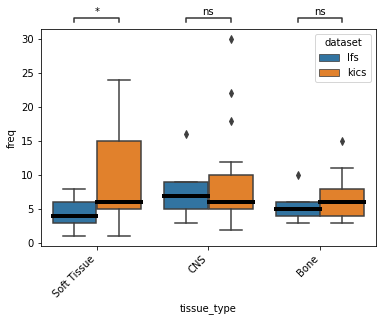

In [26]:
graphSVTissue(kInv, lInv, True)

LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
49      4329   4329  Soft Tissue              RMS     8     lfs          NaN   

   CCP germline  
49          NaN  
the outliers for RMS are:
['4329']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
57  PD13489b  PD13489b        Bone               OS    10     lfs   

   tumour_class CCP germline  
57          NaN          NaN  
the outliers for OS are:
['PD13489b']

KICS
Empty DataFrame
Columns: [sample_id, sample, tissue_type, cancer_diagnosis, freq, dataset, tumour_class, CCP germline]
Index: []
the outliers for RMS are:
[]

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
7    271112    NaN        Bone               OS    15    kics  SOLID TUMORS   

  CCP germline  
7       271112  
the outliers for OS are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***

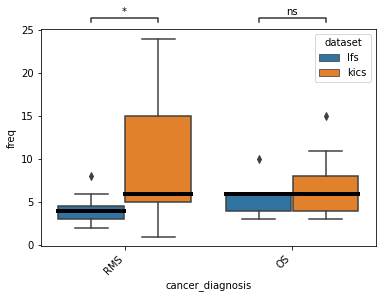

In [27]:
graphSVTissue(kInv, lInv, False)


  sample_id tissue_type    0
0      3356         CNS  322
the outliers for CNS are:
['3356']

  sample_id tissue_type    0
1  PD13489b        Bone  242
the outliers for Bone are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, tissue_type, 0]
Index: []
the outliers for Adrenal are:
[]

   sample_id  tissue_type    0
7       3763  Soft Tissue  164
62      2349  Soft Tissue   73
the outliers for Soft Tissue are:
['3763', '2349']

   sample_id tissue_type    0
12      4257      Breast  153
the outliers for Breast are:
['4257']

   sample_id tissue_type   0
63      2447  Unaffected  62
the outliers for Unaffected are:
['2447']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CNS vs. Bone: Mann-Whitney-Wilcoxon test two-sided, P_val:9.307e-01 U_stat=1.600e+01
Bone vs. Adrenal: Mann-Whitney-Wilcoxon test two-sided, P_val:8.665e-01 U_stat=6.950e+01
Adrenal vs

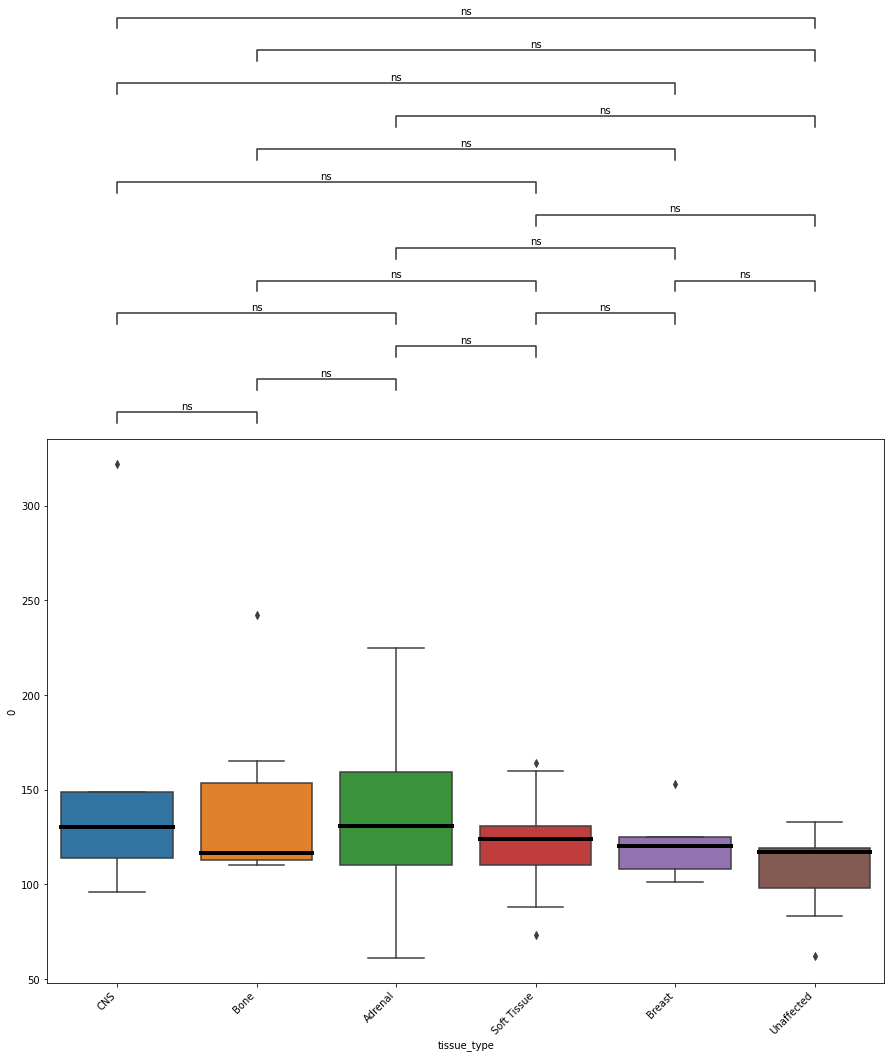

In [28]:
"""
Between Cancer Types
Make an LFS graph, a KiCS Graph
- SV Specific
- Overall <Done
"""
#overall LFS
ldf = bigLDf.drop(['GD_AF','sample','ageofonset'], axis=1)
kdf = bigKDf.drop(['CCP germline','abbv_id','tumour_class','ageofonset'],axis=1)

#print(ldf)
ldfGenTissue = ldf.drop(['SV chrom', 'SV type', 'cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)


65
Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

  sample_id SV type  freq dataset
0      3356     DEL   276  cancer
1  PD13489b     DEL   221  cancer
2      3425     DEL   195  cancer
3      3365     DEL   180  cancer
the outliers for cancer are:
['3356', 'PD13489b', '3425', '3365']

Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    sample_id SV type  freq dataset
0  SJACT005_G     DUP    40  cancer
1        3356     DUP    30  cancer
2        2957     DUP    22  cancer
3        3425     DUP    21  cancer
the outliers for cancer are:
['SJACT005_G', '3356', '2957', '3425']

Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    sample_id SV type  freq dataset
0        3365     INV    21  cancer
1  SJACT005_G     INV    21  cancer
2        3356     INV    16  cancer
the outliers for cancer are:
['3365', 'SJAC

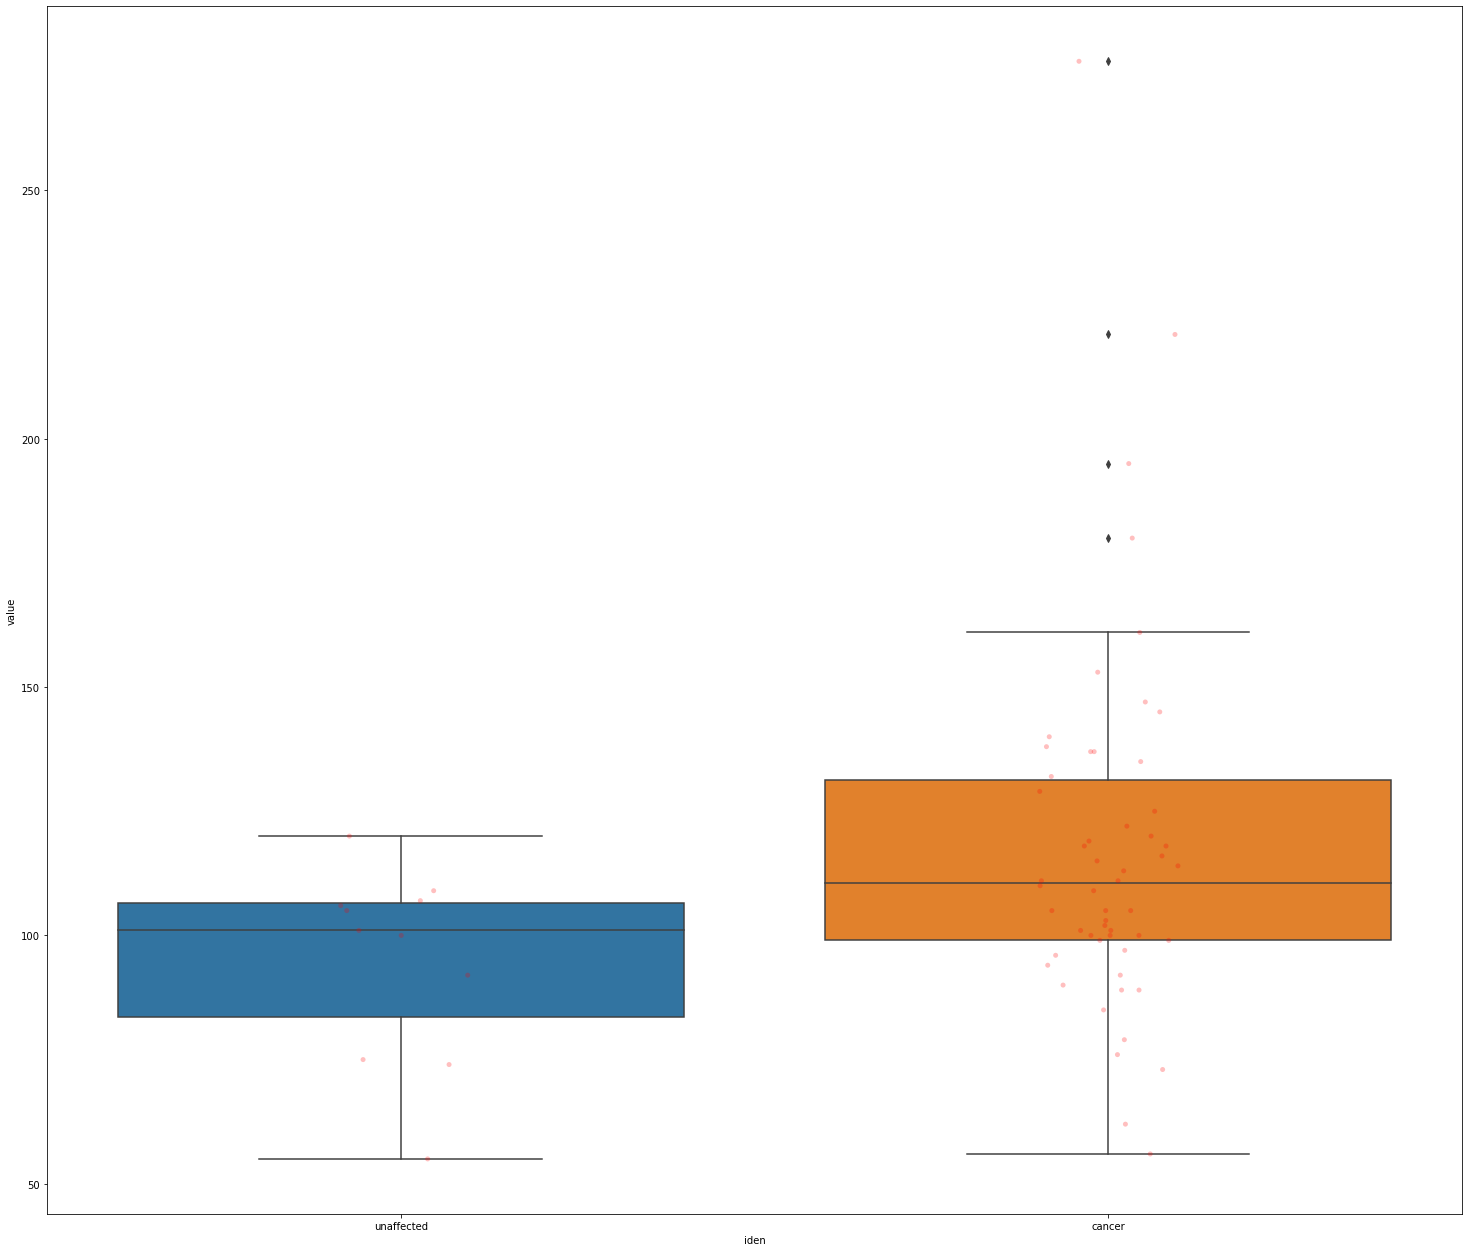

MannwhitneyuResult(statistic=266.0, pvalue=0.5920316326069894)


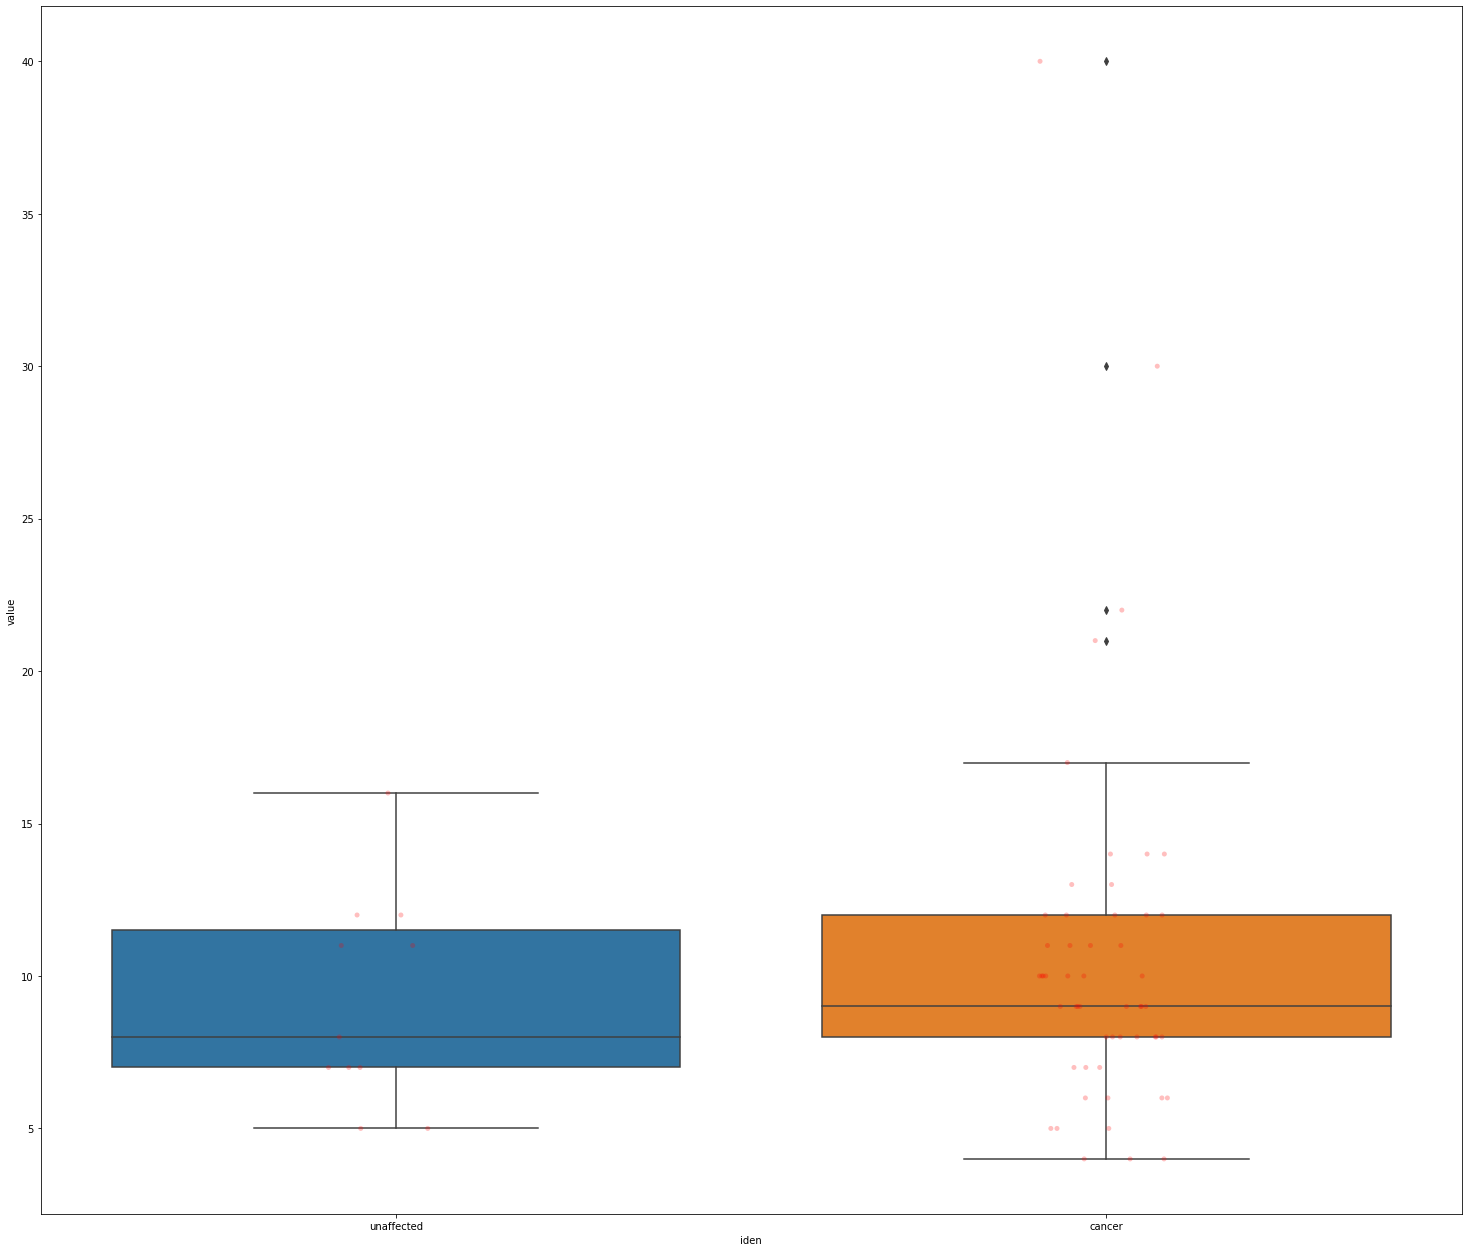

MannwhitneyuResult(statistic=191.0, pvalue=0.08454067588286607)


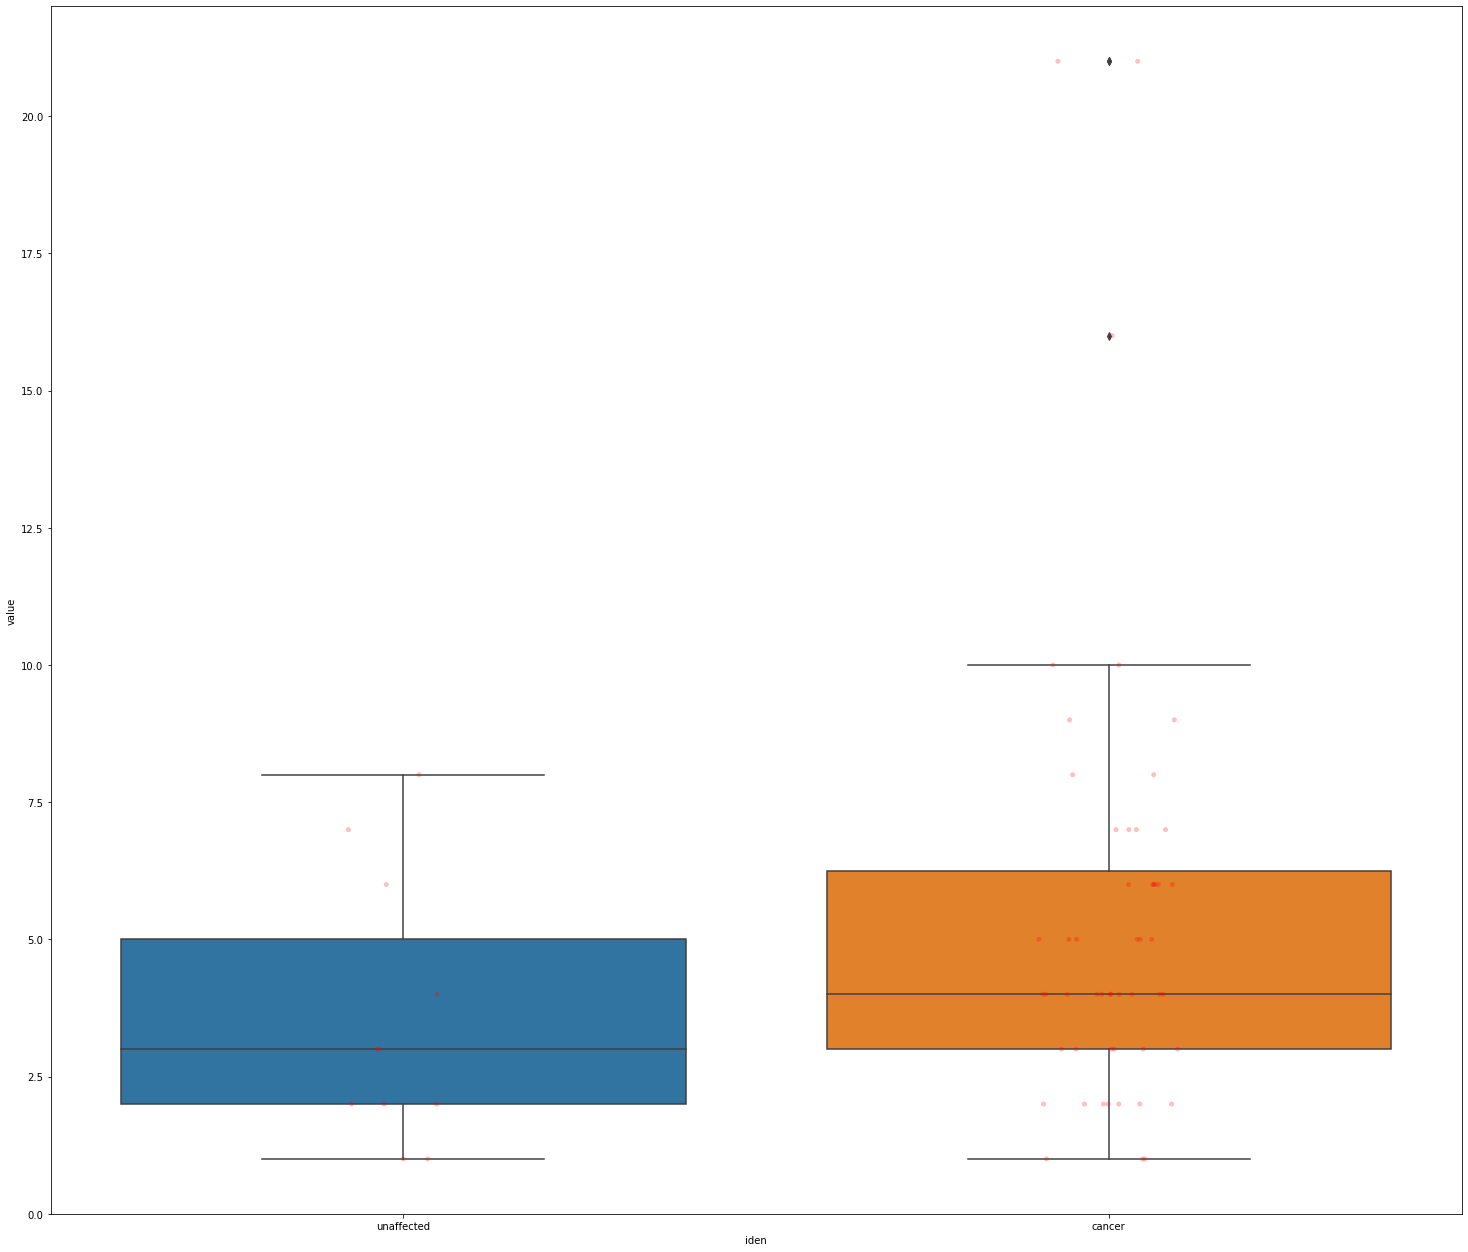

In [29]:
"""
LFS vs Unaffected
"""
#3 big graphs for SV type lfs vs unaffected

#both the tissue_type and cancer_diagnosis have the same unaffected

unaffectedDf = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                                 'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)
cancerDf = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)
print(bigLDf['sample_id'].nunique())

uDel = unaffectedDf[unaffectedDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()
uDel = uDel.rename(columns={0:'freq'})
uDel['dataset']='unaffected'
cDel = cancerDf[cancerDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()
cDel = cDel.rename(columns={0:'freq'})
cDel['dataset']='cancer'
mergedDel = pd.DataFrame(data = {'unaffected':uDel['freq'],'cancer':cDel['freq']})

outliersInDf(pd.concat([uDel,cDel]),'dataset','freq')


uDup = unaffectedDf[unaffectedDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
uDup = uDup.rename(columns={0:'freq'})
uDup['dataset']='unaffected'
cDup = cancerDf[cancerDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
cDup = cDup.rename(columns={0:'freq'})
cDup['dataset']='cancer'
mergedDup = pd.DataFrame(data = {'unaffected':uDup['freq'],'cancer':cDup['freq']})

outliersInDf(pd.concat([uDup,cDup]),'dataset','freq')


uInv = unaffectedDf[unaffectedDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
uInv = uInv.rename(columns={0:'freq'})
uInv['dataset']='unaffected'
cInv = cancerDf[cancerDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
cInv = cInv.rename(columns={0:'freq'})
cInv['dataset']='cancer'
mergedInv = pd.DataFrame(data = {'unaffected':uInv['freq'],'cancer':cInv['freq']})

outliersInDf(pd.concat([uInv,cInv]),'dataset','freq')


#print(mergedInv)
title = ['unaffected','cancer']

boxplotPoints(title, title, mergedDel)
boxplotPoints(title, title, mergedDup)
boxplotPoints(title, title, mergedInv)


  sample_id cancer_diagnosis    0
1  PD13489b               OS  242
the outliers for OS are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, 0]
Index: []
the outliers for ACC are:
[]

   sample_id cancer_diagnosis   0
62      2349              RMS  73
the outliers for RMS are:
['2349']

   sample_id cancer_diagnosis    0
12      4257           Breast  153
the outliers for Breast are:
['4257']

   sample_id cancer_diagnosis   0
63      2447       Unaffected  62
the outliers for Unaffected are:
['2447']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OS vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:7.203e-01 U_stat=4.650e+01
ACC vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:6.670e-01 U_stat=1.045e+02
RMS vs. Breast: Mann-Whitney-Wilcoxon test two-sided, P_val:3.636e-01 U_stat=3.000e+01
Breast vs. Unaffected: Mann-Whitney-

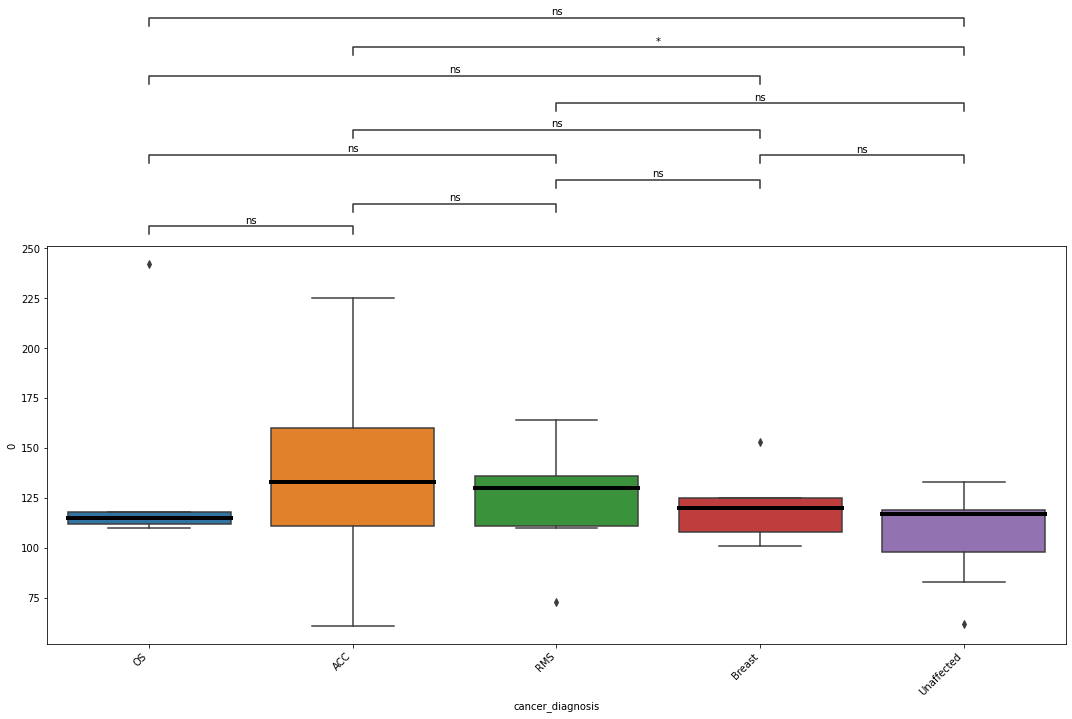

In [30]:
ldfGenDiag = ldf.drop(['SV chrom', 'SV type', 'tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

      sample_id  tissue_type    0
0        284386  Soft Tissue  532
1        286909          CNS  484
2        300683          CNS  472
3        316626        Other  447
4        271112         Bone  417
..          ...          ...  ...
88       297445          CNS  101
89       299338          CNS  100
90       305577        Other   93
91  N_-_18_2697       Breast   85
92       299321        Other   73

[93 rows x 3 columns]
  sample_id  tissue_type    0
0    284386  Soft Tissue  532
the outliers for Soft Tissue are:
['284386']

  sample_id tissue_type    0
1    286909         CNS  484
2    300683         CNS  472
6    271116         CNS  369
the outliers for CNS are:
['286909', '300683', '271116']

  sample_id tissue_type    0
3    316626       Other  447
the outliers for Other are:
['316626']

  sample_id tissue_type    0
4    271112        Bone  417
the outliers for Bone are:
['271112']

Empty DataFrame
Columns: [sample_id, tissue_type, 0]
Index: []
the outliers for US are:
[]

  

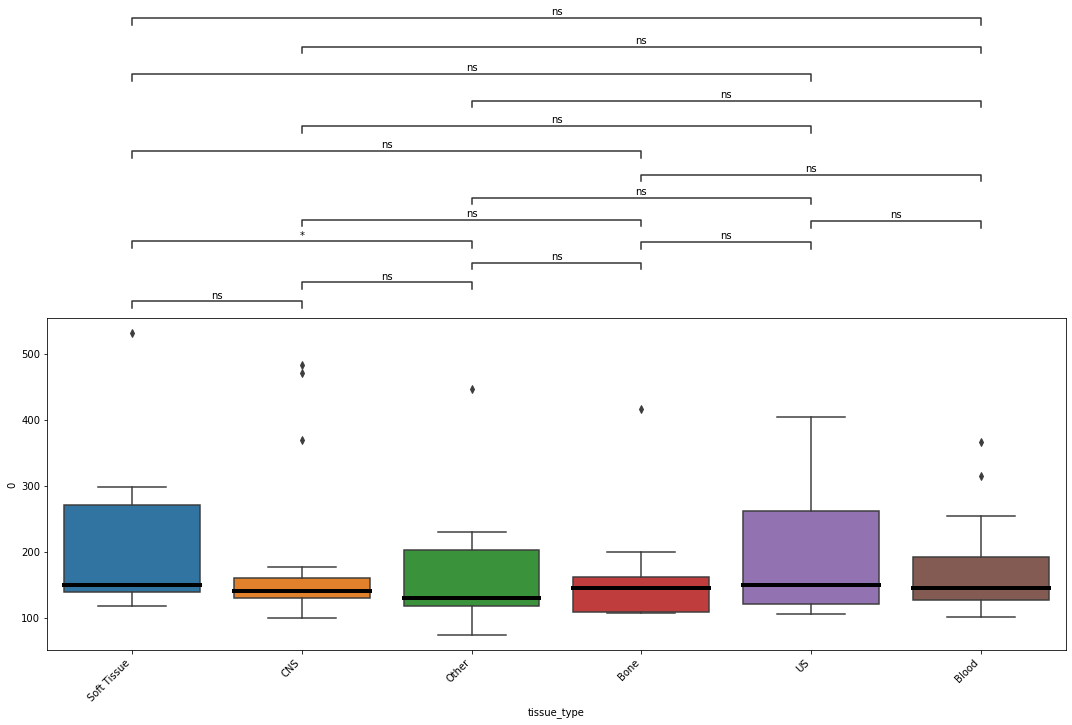

In [31]:
"""
Overall Kics
""" 
kdfGenTissue = kdf.drop(['SV type', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
print(kdfGenTissue)
graphBoxGen('tissue_type', kdfGenTissue)

  sample_id cancer_diagnosis    0
0    284386              RMS  532
the outliers for RMS are:
['284386']

  sample_id cancer_diagnosis    0
1    286909           Glioma  484
2    300683           Glioma  472
the outliers for Glioma are:
['286909', '300683']

  sample_id cancer_diagnosis    0
3    316626            Other  447
the outliers for Other are:
['316626']

  sample_id cancer_diagnosis    0
4    271112               OS  417
the outliers for OS are:
['271112']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, 0]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

  sample_id cancer_diagnosis    0
8    319104            B-ALL  315
the outliers for B-ALL are:
['319104']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Glioma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.232e-01 U_stat=1.560e+02
Glioma vs. Other: Mann-Whitney-Wi

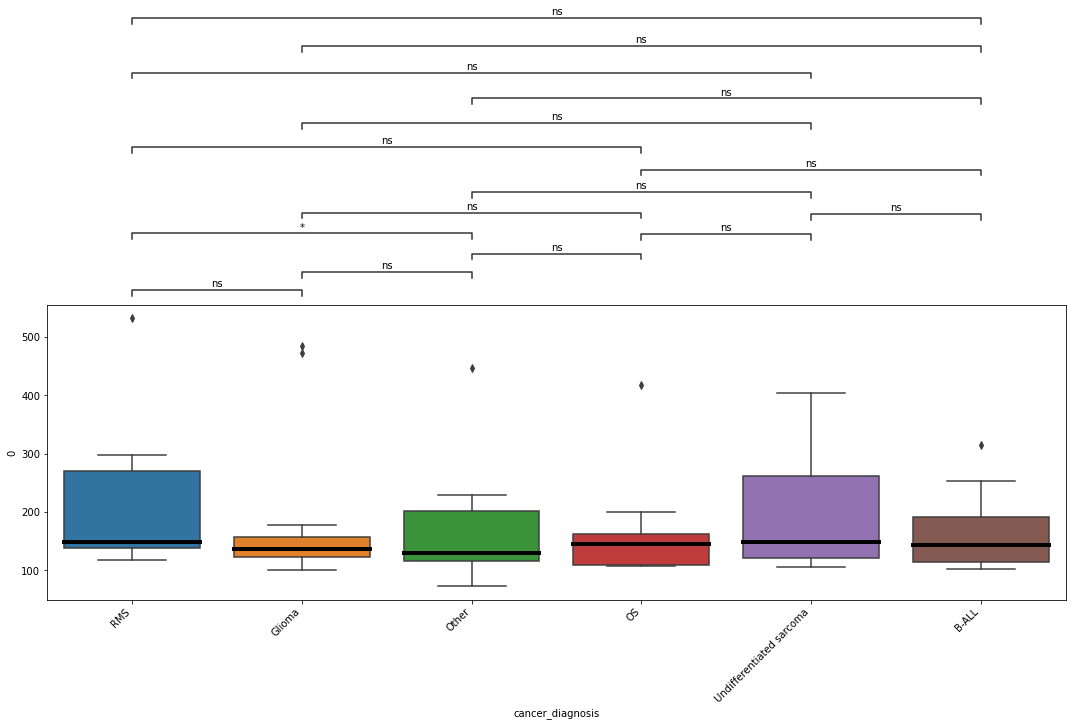

In [32]:
#overall cancer diagnosis
kdfGenDiag = kdf.drop(['SV type', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

SV type sample_id tissue_type  DEL
65         316626       Other  393
the outliers for Other are:
['316626']

SV type sample_id tissue_type  DEL
66         316747       Blood  302
72         319104       Blood  258
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  DEL
9          271116         CNS  318
16         286909         CNS  434
36         300683         CNS  392
the outliers for CNS are:
['271116', '286909', '300683']

SV type sample_id  tissue_type  DEL
14         284386  Soft Tissue  456
the outliers for Soft Tissue are:
['284386']

SV type sample_id tissue_type  DEL
7          271112        Bone  366
the outliers for Bone are:
['271112']

Empty DataFrame
Columns: [sample_id, tissue_type, DEL]
Index: []
the outliers for US are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Other vs. Blood: Mann-Whitney-Wilco

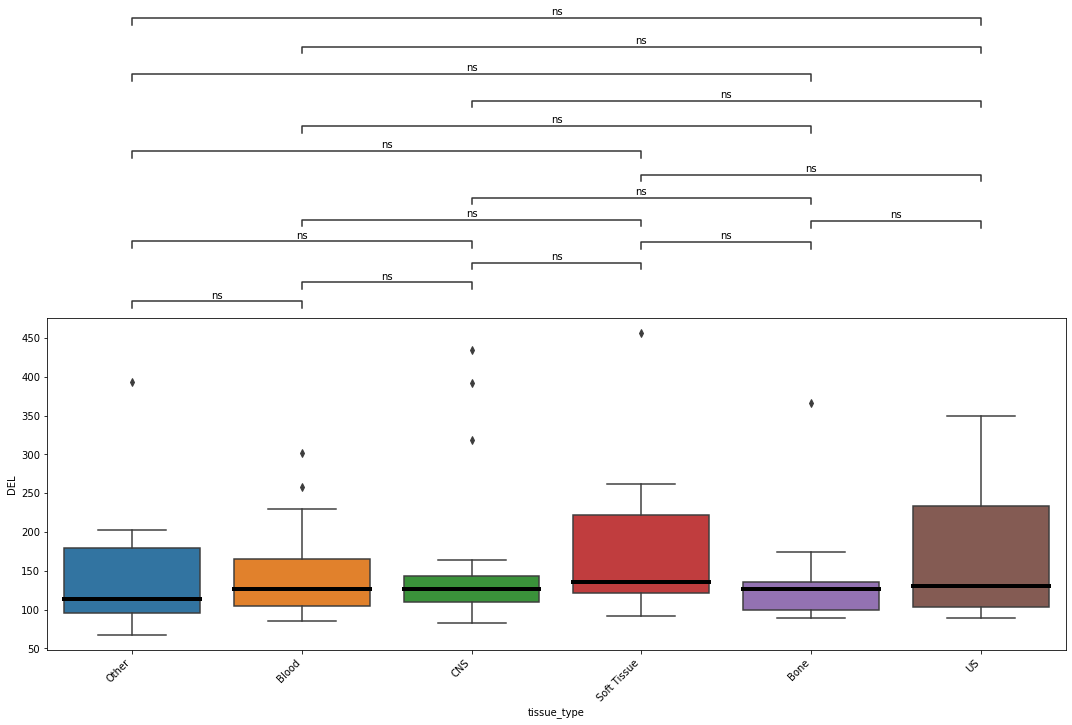

In [33]:
"""
SV Specific
"""
#Overall tissue ones
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type','tissue_type']).size()
kT = kT.unstack(1)

lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type', 'tissue_type']).size()
lT = lT.unstack(1)

graphBoxGen('tissue_type', kT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type sample_id tissue_type    DEL
31           3425     Adrenal  195.0
the outliers for Adrenal are:
['3425']

SV type sample_id  tissue_type    DEL
9            2349  Soft Tissue   62.0
41           3763  Soft Tissue  153.0
the outliers for Soft Tissue are:
['2349', '3763']

Empty DataFrame
Columns: [sample_id, tissue_type, DEL]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type    DEL
27           3356         CNS  276.0
the outliers for CNS are:
['3356']

SV type sample_id tissue_type    DEL
58       PD13489b        Bone  221.0
the outliers for Bone are:
['PD13489b']

SV type sample_id tissue_type    DEL
48           4257      Breast  137.0
the outliers for Breast are:
['4257']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:5.056e-01 U_stat=1.630e+02
Sof

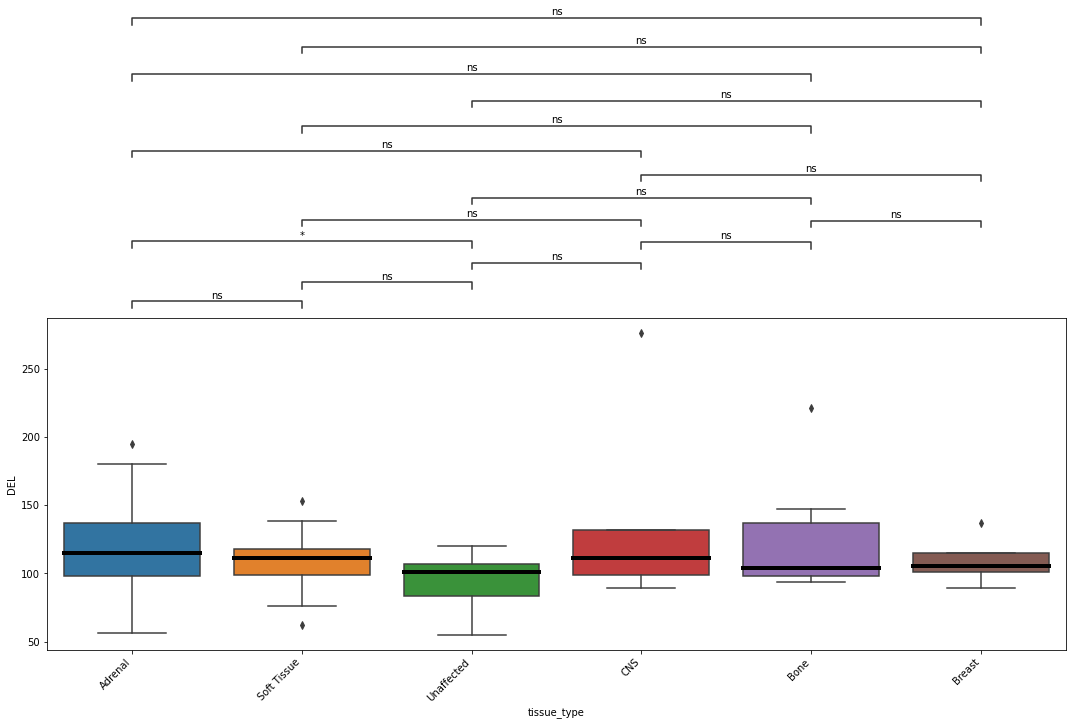

In [34]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')


SV type sample_id tissue_type  DUP
65         316626       Other   36
the outliers for Other are:
['316626']

SV type sample_id tissue_type  DUP
66         316747       Blood   38
72         319104       Blood   35
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  DUP
9          271116         CNS   33
16         286909         CNS   28
36         300683         CNS   50
the outliers for CNS are:
['271116', '286909', '300683']

SV type sample_id  tissue_type  DUP
14         284386  Soft Tissue   52
79         326693  Soft Tissue   44
the outliers for Soft Tissue are:
['284386', '326693']

SV type sample_id tissue_type  DUP
7          271112        Bone   36
the outliers for Bone are:
['271112']

SV type sample_id tissue_type  DUP
11         273309          US   38
the outliers for US are:
['273309']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
 

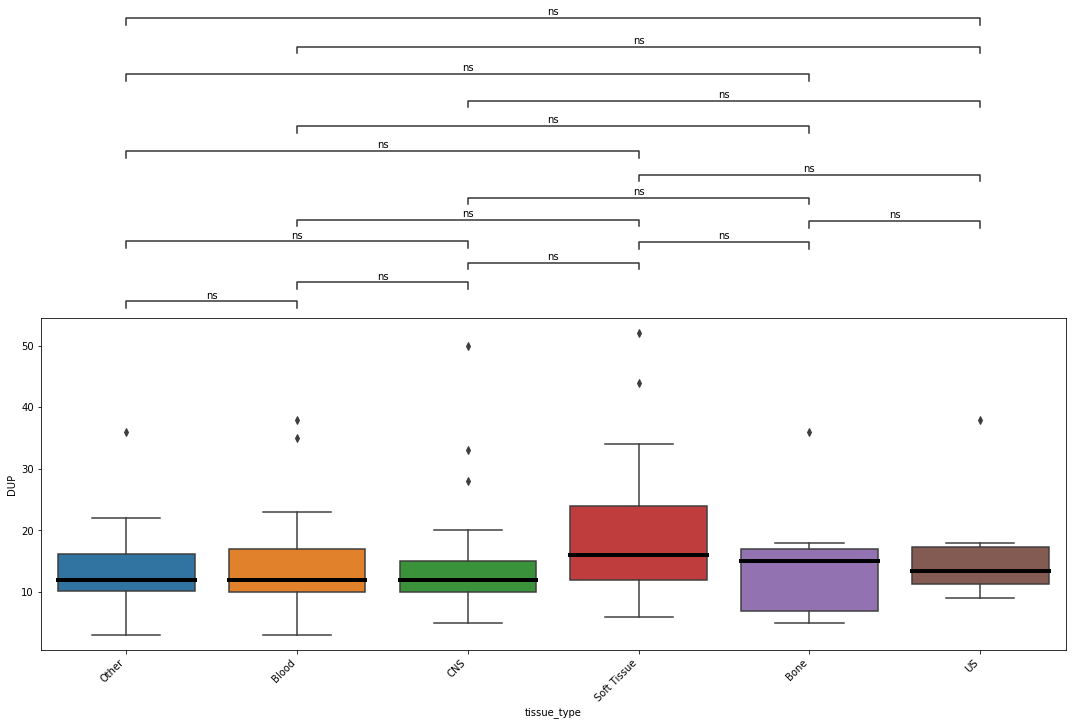

In [35]:
graphBoxGen('tissue_type', kT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type   sample_id tissue_type   DUP
20             2957     Adrenal  22.0
31             3425     Adrenal  21.0
62       SJACT005_G     Adrenal  40.0
the outliers for Adrenal are:
['2957', '3425', 'SJACT005_G']

SV type sample_id  tissue_type   DUP
49           4329  Soft Tissue  14.0
the outliers for Soft Tissue are:
['4329']

Empty DataFrame
Columns: [sample_id, tissue_type, DUP]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type   DUP
27           3356         CNS  30.0
the outliers for CNS are:
['3356']

SV type sample_id tissue_type  DUP
25           3332        Bone  6.0
the outliers for Bone are:
['3332']

Empty DataFrame
Columns: [sample_id, tissue_type, DUP]
Index: []
the outliers for Breast are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:2.1

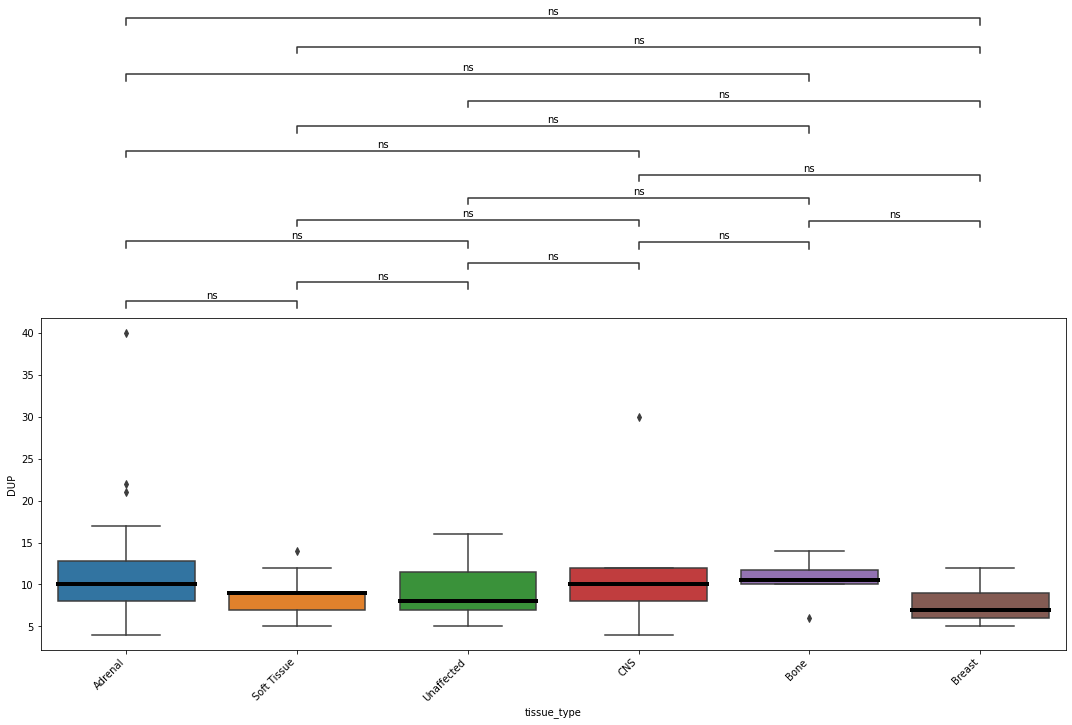

In [36]:
graphBoxGen('tissue_type', lT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Other are:
[]

SV type sample_id tissue_type  INV
66         316747       Blood   27
72         319104       Blood   22
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  INV
9          271116         CNS   18
16         286909         CNS   22
36         300683         CNS   30
the outliers for CNS are:
['271116', '286909', '300683']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Soft Tissue are:
[]

SV type sample_id tissue_type  INV
7          271112        Bone   15
the outliers for Bone are:
['271112']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for US are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Other vs. Blood: Mann-Whitney-Wilcoxon test two-sided, P_val:6.

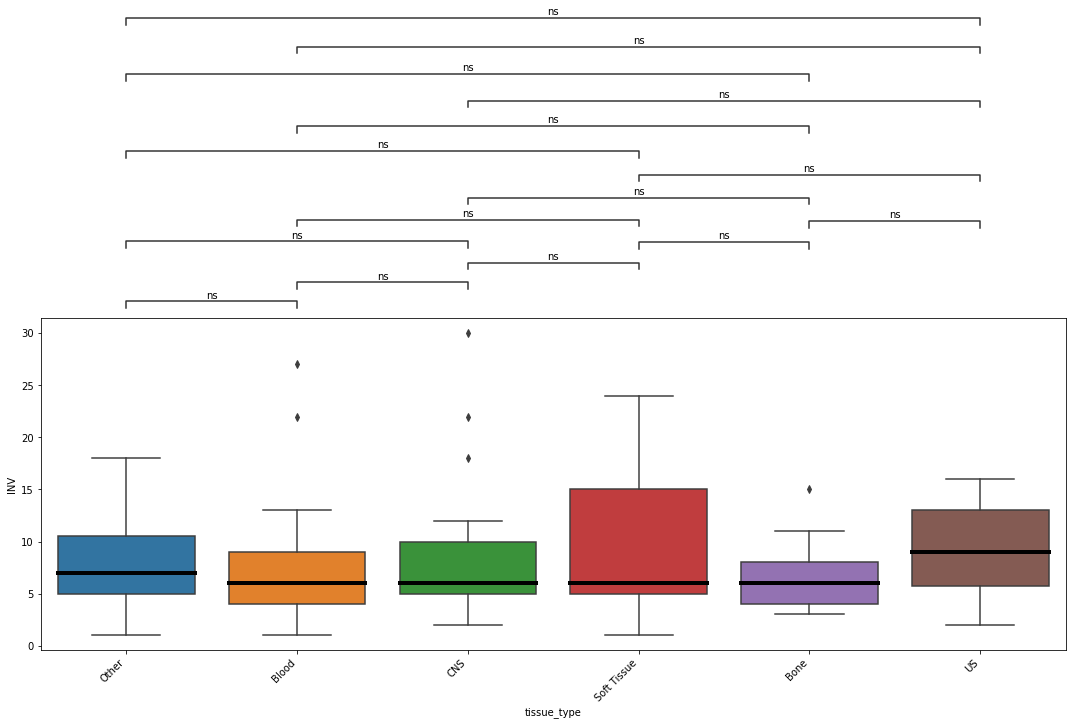

In [37]:
graphBoxGen('tissue_type', kT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type   sample_id tissue_type   INV
29             3365     Adrenal  21.0
62       SJACT005_G     Adrenal  21.0
the outliers for Adrenal are:
['3365', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Soft Tissue are:
[]

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type   INV
27           3356         CNS  16.0
the outliers for CNS are:
['3356']

SV type sample_id tissue_type   INV
58       PD13489b        Bone  10.0
the outliers for Bone are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Breast are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Adrenal vs. Soft Tissue: Mann-Whitney-Wilcoxon test two-sided, P_val:9.849e-01 U_stat=1.270e+02
Soft Tissue vs. Unaffected: Man

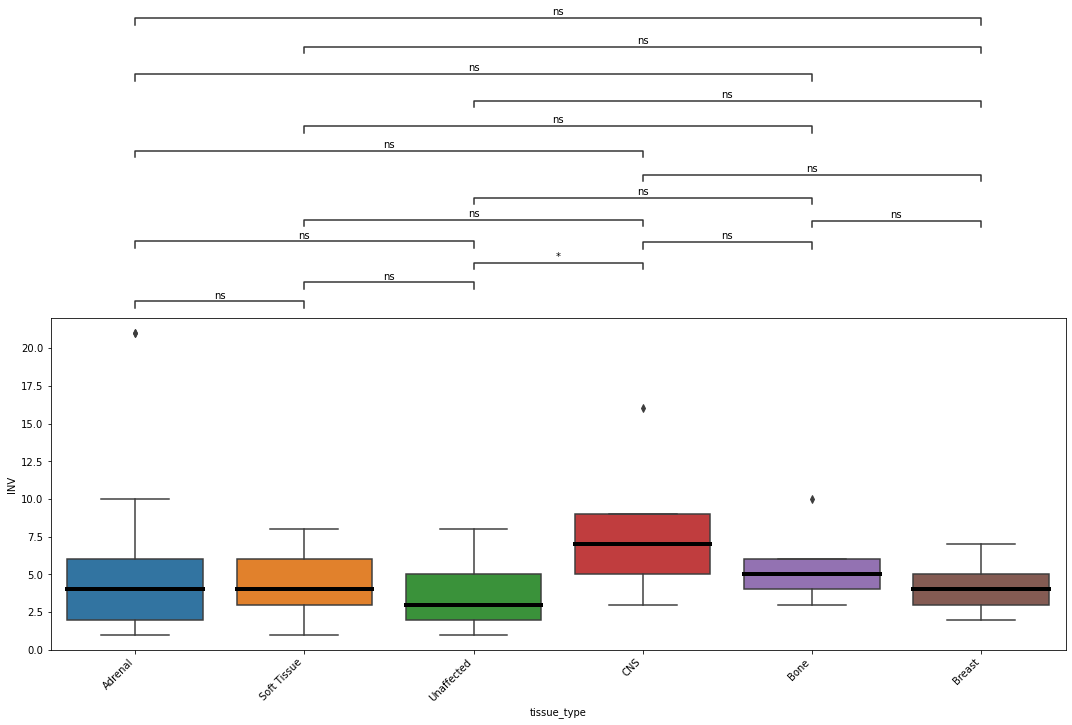

In [38]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type sample_id cancer_diagnosis  DEL
65         316626            Other  393
the outliers for Other are:
['316626']

SV type sample_id cancer_diagnosis  DEL
16         286909           Glioma  434
36         300683           Glioma  392
the outliers for Glioma are:
['286909', '300683']

SV type sample_id cancer_diagnosis  DEL
14         284386              RMS  456
the outliers for RMS are:
['284386']

SV type sample_id cancer_diagnosis  DEL
7          271112               OS  366
the outliers for OS are:
['271112']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DEL]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DEL]
Index: []
the outliers for B-ALL are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Other vs. Glioma: Mann-Whitney-Wilcoxon test two-sided, P_val:6.484e-0

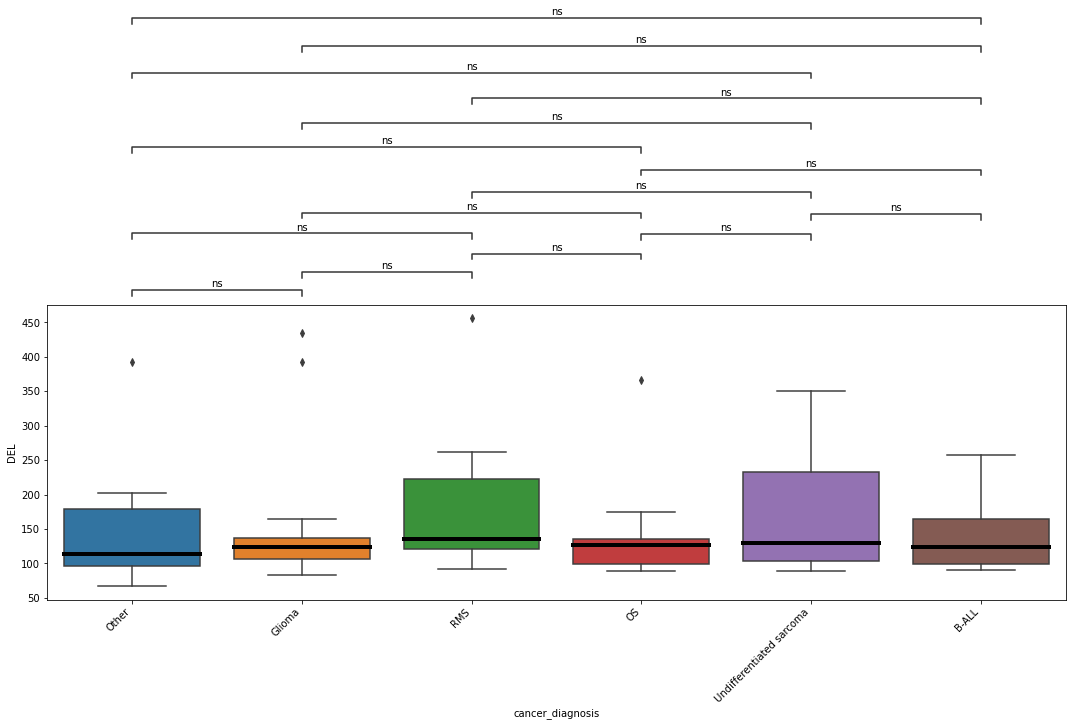

In [39]:
#diganosis, SV Specific
kD = kdf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
kD = kD.unstack(1)

lD = ldf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type sample_id cancer_diagnosis    DEL
9            2349              RMS   62.0
41           3763              RMS  153.0
the outliers for RMS are:
['2349', '3763']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DEL]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id cancer_diagnosis    DEL
31           3425              ACC  195.0
the outliers for ACC are:
['3425']

SV type sample_id cancer_diagnosis    DEL
58       PD13489b               OS  221.0
the outliers for OS are:
['PD13489b']

SV type sample_id cancer_diagnosis    DEL
48           4257           Breast  137.0
the outliers for Breast are:
['4257']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:7.398e-02 U_stat=7.350e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.494e-02 U_stat=5.85

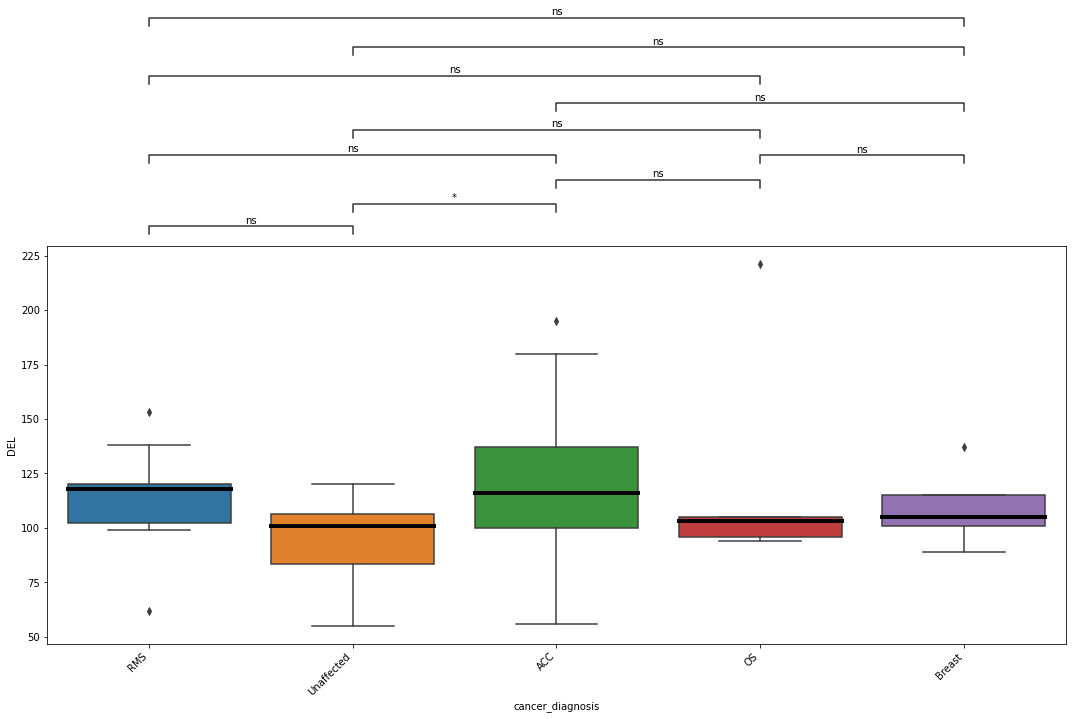

In [40]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type sample_id cancer_diagnosis  DUP
65         316626            Other   36
the outliers for Other are:
['316626']

SV type sample_id cancer_diagnosis  DUP
16         286909           Glioma   28
36         300683           Glioma   50
the outliers for Glioma are:
['286909', '300683']

SV type sample_id cancer_diagnosis  DUP
14         284386              RMS   52
79         326693              RMS   44
the outliers for RMS are:
['284386', '326693']

SV type sample_id cancer_diagnosis  DUP
7          271112               OS   36
the outliers for OS are:
['271112']

SV type sample_id          cancer_diagnosis  DUP
11         273309  Undifferentiated sarcoma   38
the outliers for Undifferentiated sarcoma are:
['273309']

SV type sample_id cancer_diagnosis  DUP
24         292600            B-ALL   23
72         319104            B-ALL   35
the outliers for B-ALL are:
['292600', '319104']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1

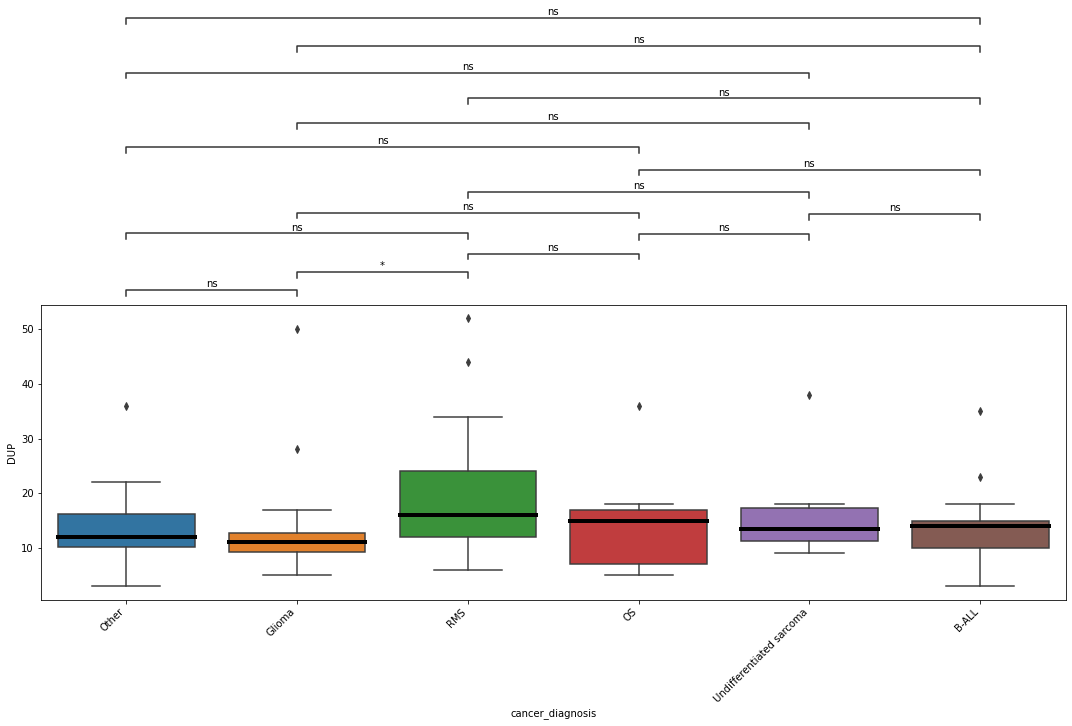

In [41]:
graphBoxGen('cancer_diagnosis', kD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type sample_id cancer_diagnosis   DUP
47           4227              RMS  12.0
49           4329              RMS  14.0
the outliers for RMS are:
['4227', '4329']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DUP]
Index: []
the outliers for Unaffected are:
[]

SV type   sample_id cancer_diagnosis   DUP
20             2957              ACC  22.0
31             3425              ACC  21.0
62       SJACT005_G              ACC  40.0
the outliers for ACC are:
['2957', '3425', 'SJACT005_G']

SV type sample_id cancer_diagnosis  DUP
25           3332               OS  6.0
the outliers for OS are:
['3332']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DUP]
Index: []
the outliers for Breast are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:6.717e-01 U_stat=5.550e+01
Unaffe

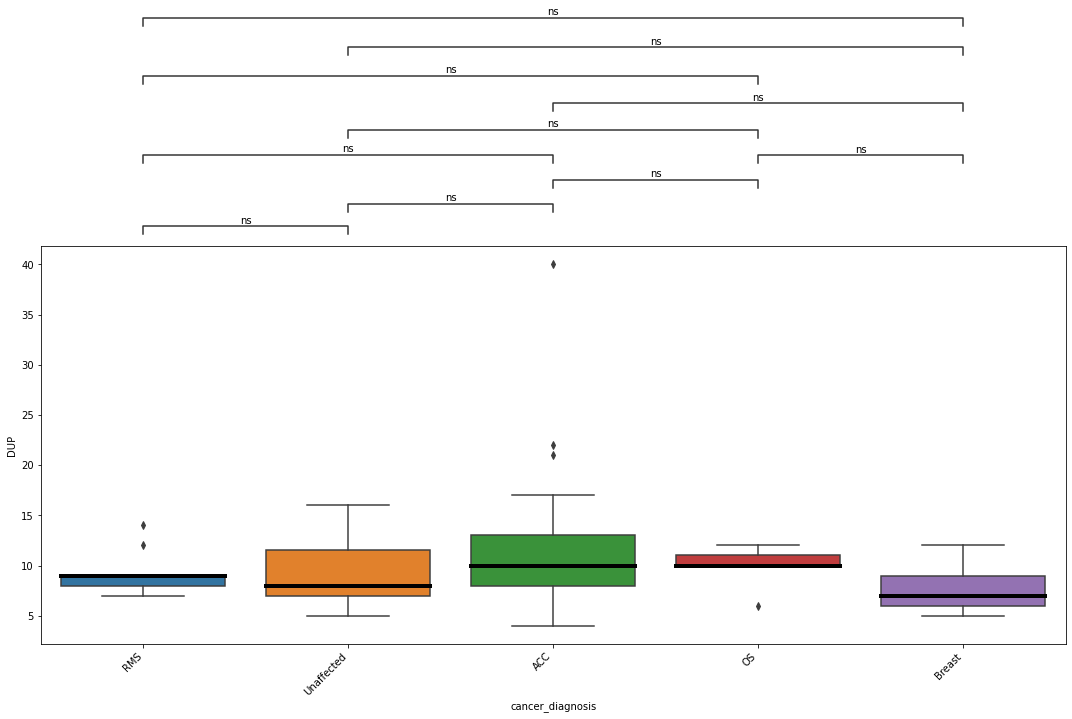

In [42]:
graphBoxGen('cancer_diagnosis', lD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Other are:
[]

SV type sample_id cancer_diagnosis  INV
16         286909           Glioma   22
36         300683           Glioma   30
the outliers for Glioma are:
['286909', '300683']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for RMS are:
[]

SV type sample_id cancer_diagnosis  INV
7          271112               OS   15
the outliers for OS are:
['271112']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Undifferentiated sarcoma are:
[]

SV type sample_id cancer_diagnosis  INV
72         319104            B-ALL   22
the outliers for B-ALL are:
['319104']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Other vs. Glioma: Mann-Whitney-Wilcoxon test two-sided, P_val:5.279e-01 U_stat=1.430e+02

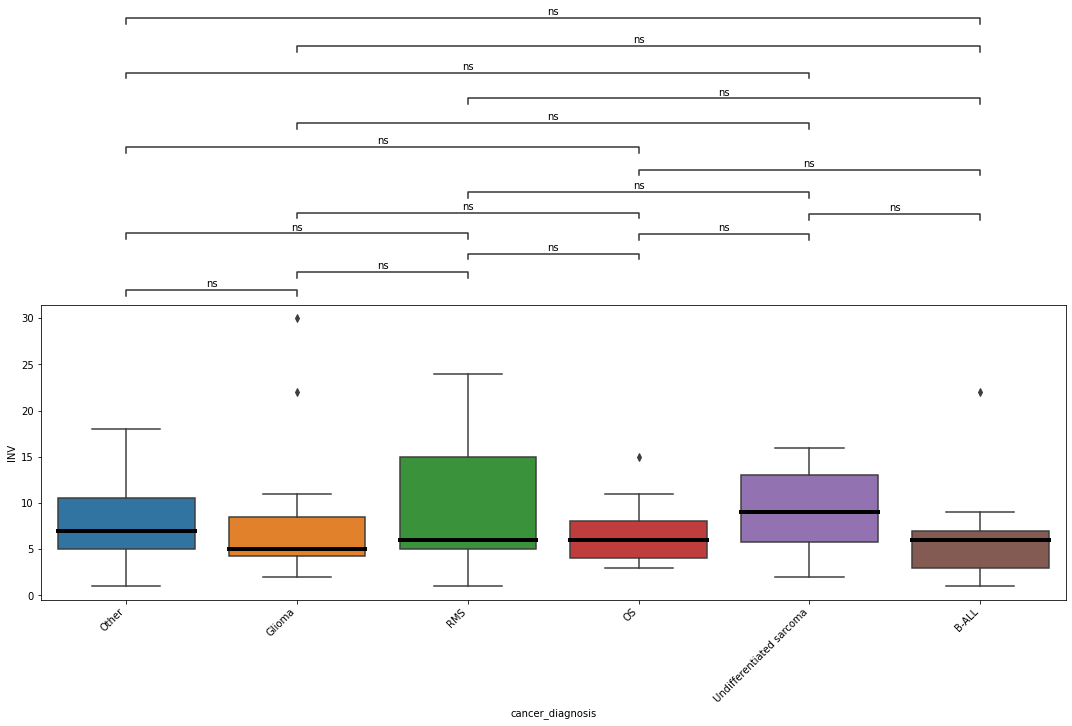

In [43]:
graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type sample_id cancer_diagnosis  INV
49           4329              RMS  8.0
the outliers for RMS are:
['4329']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Unaffected are:
[]

SV type   sample_id cancer_diagnosis   INV
29             3365              ACC  21.0
62       SJACT005_G              ACC  21.0
the outliers for ACC are:
['3365', 'SJACT005_G']

SV type sample_id cancer_diagnosis   INV
58       PD13489b               OS  10.0
the outliers for OS are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Breast are:
[]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMS vs. Unaffected: Mann-Whitney-Wilcoxon test two-sided, P_val:2.949e-01 U_stat=5.700e+01
Unaffected vs. ACC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.771e-01 U_stat=8.350e+01
ACC vs. OS:

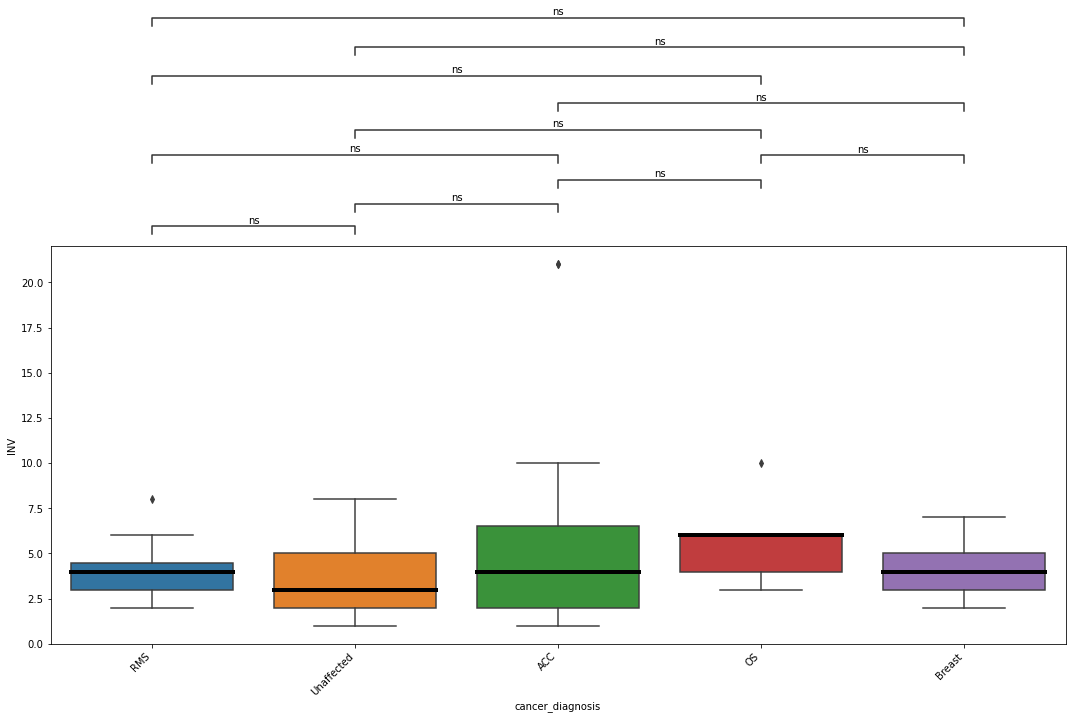

In [44]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

In [45]:
"""
LFS vs Unaffected -> done
Types of graphs:
age of onset (kics vs lfs) >SV Specific but not cancer specific
Between cancer types in kics and in lfs >done

Same for TE
"""

'\nLFS vs Unaffected -> done\nTypes of graphs:\nage of onset (kics vs lfs) >SV Specific but not cancer specific\nBetween cancer types in kics and in lfs >done\n\nSame for TE\n'

In [46]:
"SV Specific for different age of onsets"
#remove unaffected from lfs
#using diagnosis_age (days) and ageofonset || kics and lfs

lfsCancer = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
lfsUnaffected = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
kicsCancer = bigKDf.drop(['abbv_id', 'CCP germline', 'tumour_class','tissue_type','cancer_diagnosis'],axis=1)

LFS
   sample_id age6  freq dataset
47  PD13489b  >=6   242     lfs
the outliers for >=6 are:
['PD13489b']

   sample_id age6  freq dataset
18      3356   <6   322     lfs
21      3425   <6   225     lfs
the outliers for <6 are:
['3356', '3425']

  sample_id        age6  freq dataset
3      2447  Unaffected    62     lfs
the outliers for Unaffected are:
['2447']

KICS
   sample_id age6  freq dataset
11    273309   <6   404    kics
65    316626   <6   447    kics
66    316747   <6   367    kics
the outliers for <6 are:
['273309', '316626', '316747']

   sample_id age6  freq dataset
5    18_5256  >=6   292    kics
7     271112  >=6   417    kics
9     271116  >=6   369    kics
14    284386  >=6   532    kics
16    286909  >=6   484    kics
28    297377  >=6   298    kics
36    300683  >=6   472    kics
79    326693  >=6   298    kics
the outliers for >=6 are:
['18_5256', '271112', '271116', '284386', '286909', '297377', '300683', '326693']

p-value annotation legend:
      ns: p <= 1.00e

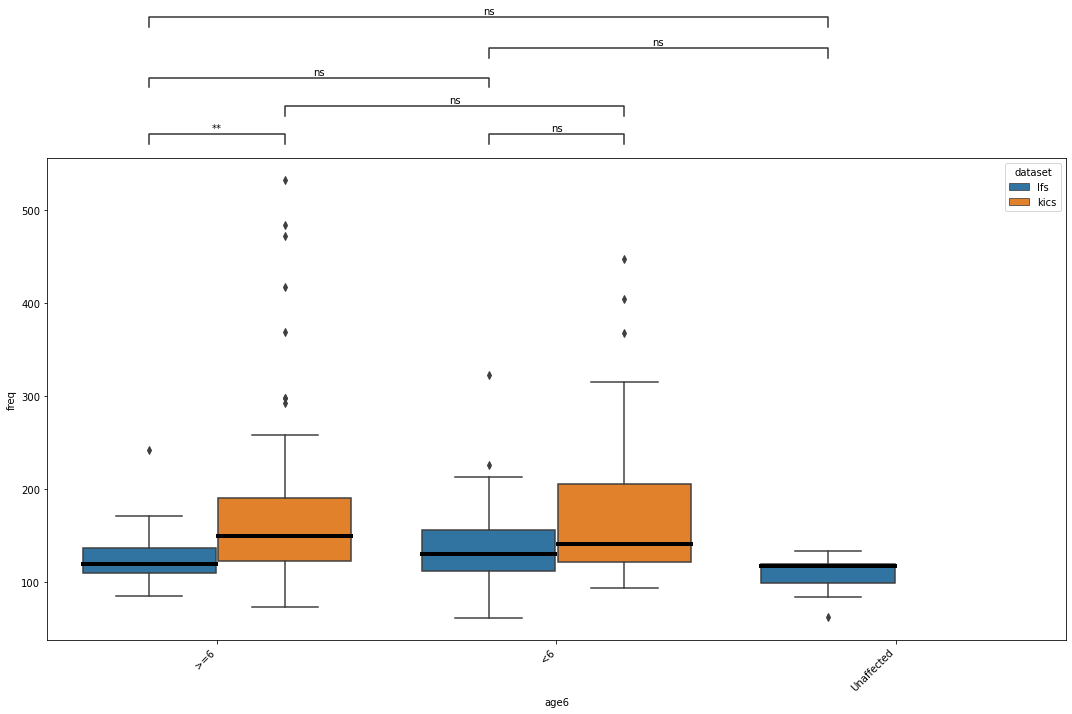

LFS
   sample_id age6  freq dataset
10     2760A  >=6   161     lfs
47  PD13489b  >=6   221     lfs
the outliers for >=6 are:
['2760A', 'PD13489b']

   sample_id age6  freq dataset
18      3356   <6   276     lfs
21      3425   <6   195     lfs
the outliers for <6 are:
['3356', '3425']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
11    273309   <6   350    kics
65    316626   <6   393    kics
66    316747   <6   302    kics
the outliers for <6 are:
['273309', '316626', '316747']

   sample_id age6  freq dataset
7     271112  >=6   366    kics
9     271116  >=6   318    kics
14    284386  >=6   456    kics
16    286909  >=6   434    kics
28    297377  >=6   266    kics
36    300683  >=6   392    kics
the outliers for >=6 are:
['271112', '271116', '284386', '286909', '297377', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 

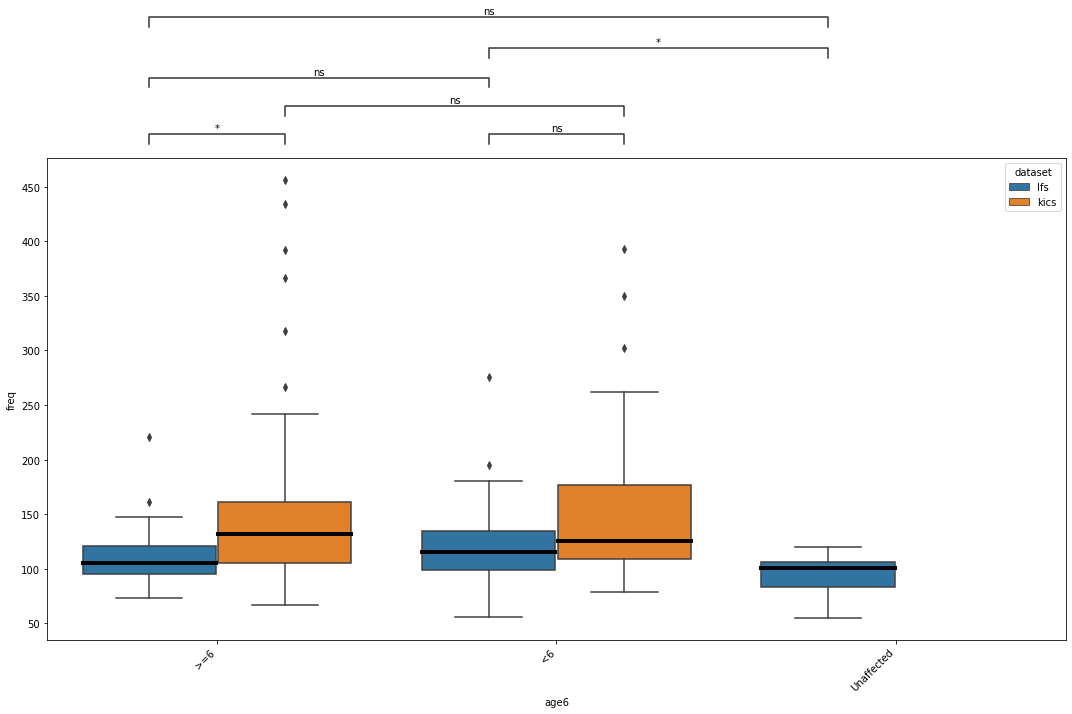

In [47]:
kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCDel = lfsCancer.loc[lfsCancer['SV type'] == 'DEL']
LUDel = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DEL']
KCDel = kicsCancer.loc[kicsCancer['SV type'] == 'DEL']

LCDup = lfsCancer.loc[lfsCancer['SV type'] == 'DUP']
LUDup = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DUP']
KCDup = kicsCancer.loc[kicsCancer['SV type'] == 'DUP']

LCInv = lfsCancer.loc[lfsCancer['SV type'] == 'INV']
LUInv = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'INV']
KCInv = kicsCancer.loc[kicsCancer['SV type'] == 'INV']

mergeDFs(lfsCancer, lfsUnaffected, kicsCancer)
    
mergeDFs(LCDel, LUDel, KCDel)

LFS
Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for >=6 are:
[]

     sample_id age6  freq dataset
13        2957   <6    22     lfs
18        3356   <6    30     lfs
21        3425   <6    21     lfs
51  SJACT005_G   <6    40     lfs
the outliers for <6 are:
['2957', '3356', '3425', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
11    273309   <6    38    kics
59    315488   <6    34    kics
65    316626   <6    36    kics
66    316747   <6    38    kics
72    319104   <6    35    kics
the outliers for <6 are:
['273309', '315488', '316626', '316747', '319104']

   sample_id age6  freq dataset
5    18_5256  >=6    36    kics
7     271112  >=6    36    kics
9     271116  >=6    33    kics
14    284386  >=6    52    kics
36    300683  >=6    50    kics
79    326693  >=6    44    kics
the outliers for >=6 are:
['18_5256', '271112', '271116', '2

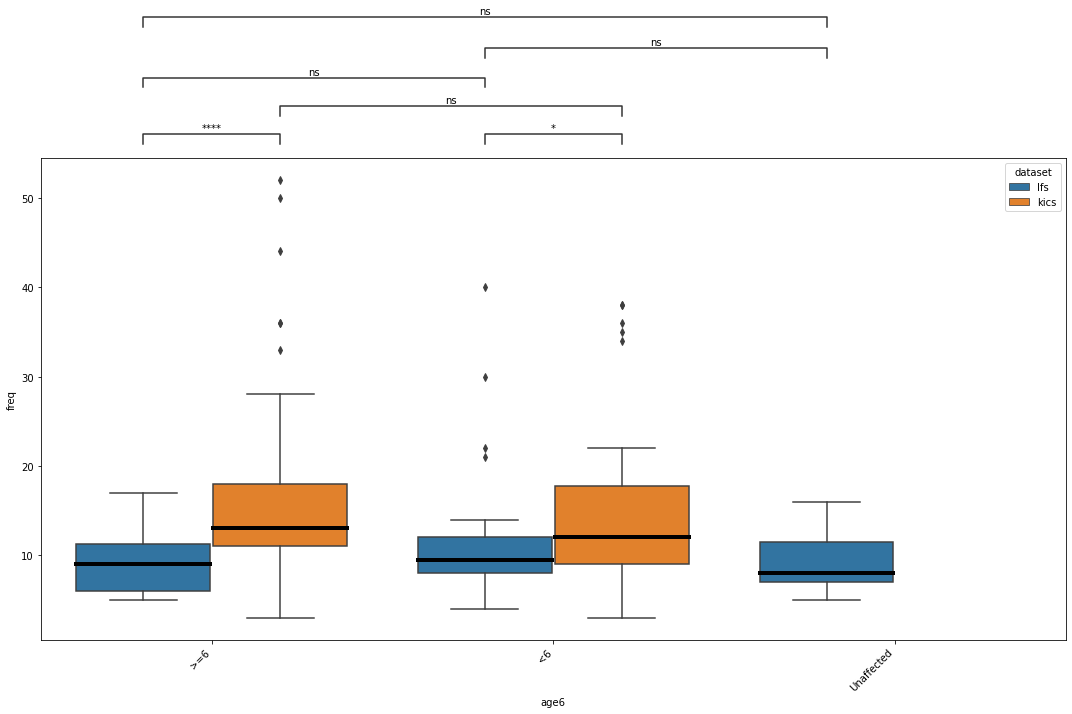

In [48]:
mergeDFs(LCDup, LUDup, KCDup)

LFS
   sample_id age6  freq dataset
46  PD13489b  >=6    10     lfs
the outliers for >=6 are:
['PD13489b']

     sample_id age6  freq dataset
19        3365   <6    21     lfs
49  SJACT005_G   <6    21     lfs
the outliers for <6 are:
['3365', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
66    316747   <6    27    kics
72    319104   <6    22    kics
the outliers for <6 are:
['316747', '319104']

   sample_id age6  freq dataset
14    284386  >=6    24    kics
16    286909  >=6    22    kics
36    300683  >=6    30    kics
the outliers for >=6 are:
['284386', '286909', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.551e-02 U_stat=3.780e+02
>=6_lfs vs. >=6_kics: Mann-Whi

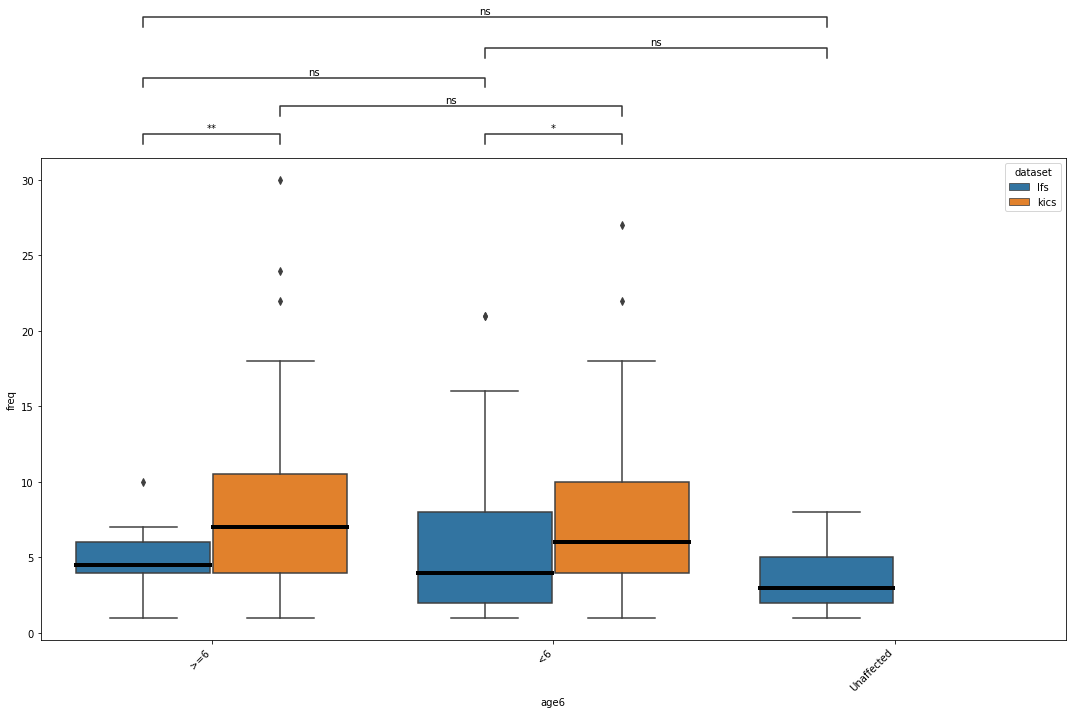

In [49]:
mergeDFs(LCInv, LUInv, KCInv)

   sample_id    cancer_diagnosis                         cancer1    0
0       1092                 MFH  Malignant fibrous histiocytoma  124
1       1355                 RMS                 Anaplastic ERMS  130
2       1843  High Grade Sarcoma              High Grade Sarcoma  117
3       2085                 RMS                       ARMS_ERMS  131
4       2262                 RMS                 Anaplastic ERMS  126
5       2349                 RMS                 Anaplastic ERMS   73
6       2463                 LMS                  Leiomyosarcoma   88
7      3136A                 RMS                 Anaplastic ERMS  110
8       3634                 MFS                Myxofibrosarcoma  103
9       3763                 RMS                 Anaplastic ERMS  164
10      4227                 RMS       Alveolar Rhabdomyosarcoma  136
11      4329                 RMS      Embryonal rhabdomyosarcoma  160
12        93                 RMS                Rhabdomyosarcoma  111
p-value annotation l

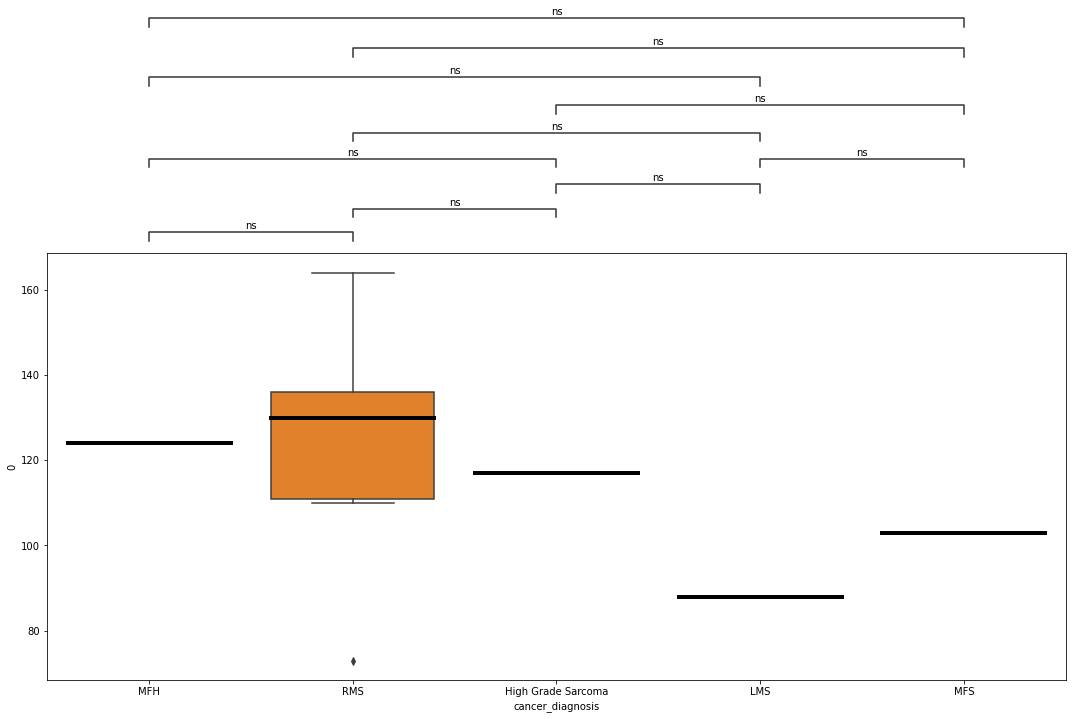

      sample_id                                      type  freq dataset  \
0       18_4156  8910/3 - Embryonal rhabdomyosarcoma, NOS   147    kics   
1       18_7027        8920/3 - Alveolar rhabdomyosarcoma   149    kics   
2        273308        8920/3 - Alveolar rhabdomyosarcoma   288    kics   
3        284386  8910/3 - Embryonal Rhabdomyosarcoma, NOS   532    kics   
4        297043  8910/3 - Embryonal rhabdomyosarcoma, NOS   131    kics   
5        298866  8910/3 - Embryonal Rhabdomyosarcoma, NOS   132    kics   
6        305082  8910/3 - Embryonal rhabdomyosarcoma, NOS   258    kics   
7        315488        8920/3 - Alveolar rhabdomyosarcoma   271    kics   
8        326693  8910/3 - Embryonal rhabdomyosarcoma, NOS   298    kics   
9        332546  8910/3 - Embryonal rhabdomyosarcoma, NOS   236    kics   
10       332700  8910/3 - Embryonal rhabdomyosarcoma, NOS   118    kics   
11  N_-_18_5639        8920/3 - Alveolar rhabdomyosarcoma   148    kics   
12   N_-_333809        89

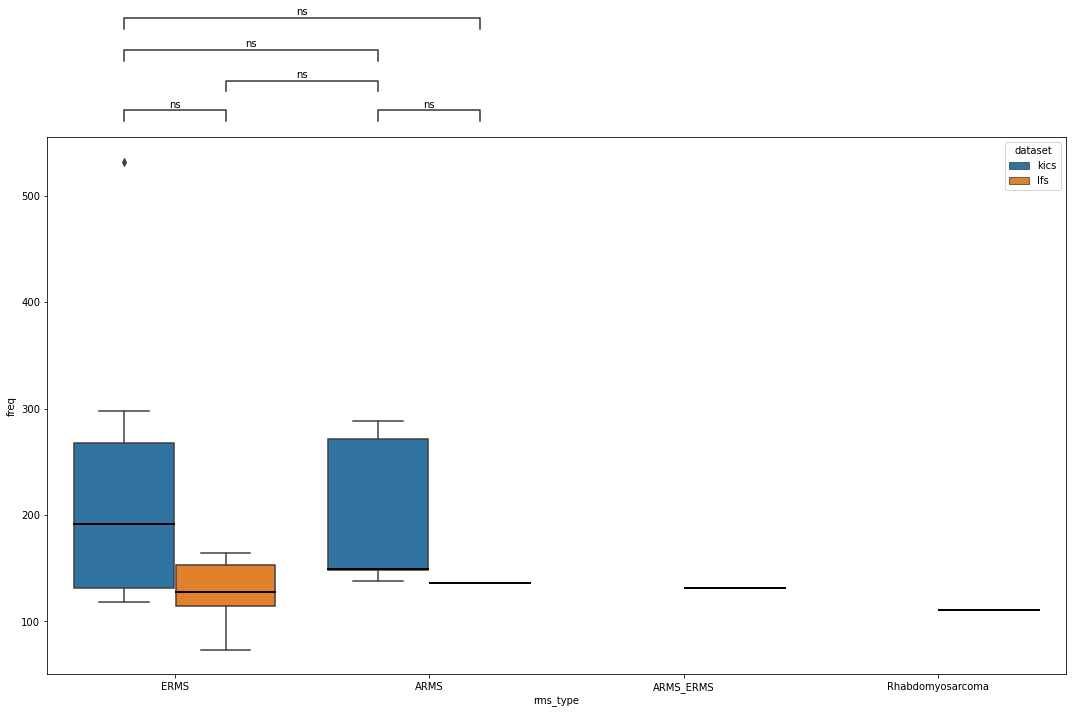

In [50]:
"""
Those in RMS are they A RMS or E RMS (cancer diagnosis)
Those in Soft Tissue, What group are they? (tissue_type)
"""
rmsKDf = UberbigKDf[['sample_id','ICDO-diagnosis','tissue_type','lfs_cancer_type_diagnosis']]
rmsLDf = UberbigLDf[['sample_id','cancer1','tissue_type','cancer_diagnosis']]

#stKDf = rmsKDf.loc[rmsKDf['tissue_type']=='Soft Tissue']
rmsKDf = rmsKDf.loc[rmsKDf['lfs_cancer_type_diagnosis']=='RMS']

#they are the same for kics
#print(rmsKDf['sample_id'].unique())
#print(stKDf['sample_id'].unique())

rmsKDf = rmsKDf.drop(['tissue_type','lfs_cancer_type_diagnosis'], axis=1).groupby(['sample_id']).value_counts().to_frame().reset_index()
rmsKDf['dataset']='kics'

#these are not the same for lfs
stLDf = rmsLDf.loc[rmsLDf['tissue_type']=='Soft Tissue']
stLDf = stLDf.drop(['tissue_type'],axis=1).groupby(['sample_id','cancer_diagnosis']).value_counts().to_frame().reset_index()

print(stLDf)

ax = sns.boxplot(data=stLDf, x='cancer_diagnosis', y=0, medianprops={"linewidth": 4, 'color':'black'})
    
uniqueList = list(stLDf['cancer_diagnosis'].unique())
listPairing = [(a,b) for x, a in enumerate(uniqueList) for b in uniqueList[x+1:]]
        
annot = Annotator(ax, listPairing, data=stLDf, x='cancer_diagnosis', y=0)
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

rmsLDf = rmsLDf.loc[rmsLDf['cancer_diagnosis']=='RMS']
rmsLDf = rmsLDf.drop(['tissue_type','cancer_diagnosis'], axis=1).groupby(['sample_id']).value_counts().to_frame().reset_index()
rmsLDf['dataset']='lfs'


rmsLDf = rmsLDf.rename(columns={'cancer1': 'type',0:'freq'})
rmsKDf = rmsKDf.rename(columns={'ICDO-diagnosis':'type', 0:'freq'})

rmsLDf['rms_type'] = rmsLDf.apply(lambda row: rmsType(row), axis=1)
rmsKDf['rms_type'] = rmsKDf.apply(lambda row: rmsType(row), axis=1)

mergedRMS = pd.concat([rmsKDf,rmsLDf])
print(mergedRMS)

bx = sns.boxplot(data=mergedRMS, x='rms_type', y='freq',hue = 'dataset', medianprops={"linewidth": 2, 'color':'black'})

listPairing = [(('ERMS','kics'),('ERMS','lfs')), (('ERMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','lfs')), (('ARMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','kics'))]

annot = Annotator(bx, listPairing, data=mergedRMS, x='rms_type', y='freq',hue = 'dataset')
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

In [51]:
"""
Search for and print the entire row given sample_id
"""
kid = '271112'

lid = 'PD13489b'
print(UberbigLDf.loc[UberbigLDf['sample_id']== lid])

     sample_id SV chrom     GD_AF SV type    sample   meth_id  p53  tm_donor  \
4083  PD13489b        1 -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4084  PD13489b        1  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   
4085  PD13489b        1  0.009751     DEL  PD13489b  PD13489b  Mut  PD13489b   
4086  PD13489b        1 -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4087  PD13489b        1  0.002701     DEL  PD13489b  PD13489b  Mut  PD13489b   
...        ...      ...       ...     ...       ...       ...  ...       ...   
4320  PD13489b        X -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4321  PD13489b        X  0.000047     DUP  PD13489b  PD13489b  Mut  PD13489b   
4322  PD13489b        X  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   
4323  PD13489b        X  0.000141     DEL  PD13489b  PD13489b  Mut  PD13489b   
4324  PD13489b        X  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   

     tissue_type cancer_diagnosis  ... 